In [126]:
import math
import json
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from pathlib import Path
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA

INTERVAL = 60

	Clustering...                                                                      


{'icoord': [[55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [35.0, 35.0, 52.5, 52.5],
  [25.0, 25.0, 43.75, 43.75],
  [15.0, 15.0, 34.375, 34.375],
  [5.0, 5.0, 24.6875, 24.6875],
  [75.0, 75.0, 85.0, 85.0],
  [675.0, 675.0, 685.0, 685.0],
  [665.0, 665.0, 680.0, 680.0],
  [655.0, 655.0, 672.5, 672.5],
  [645.0, 645.0, 663.75, 663.75],
  [635.0, 635.0, 654.375, 654.375],
  [625.0, 625.0, 644.6875, 644.6875],
  [615.0, 615.0, 634.84375, 634.84375],
  [605.0, 605.0, 624.921875, 624.921875],
  [595.0, 595.0, 614.9609375, 614.9609375],
  [585.0, 585.0, 604.98046875, 604.98046875],
  [575.0, 575.0, 594.990234375, 594.990234375],
  [565.0, 565.0, 584.9951171875, 584.9951171875],
  [555.0, 555.0, 574.99755859375, 574.99755859375],
  [545.0, 545.0, 564.998779296875, 564.998779296875],
  [535.0, 535.0, 554.9993896484375, 554.9993896484375],
  [525.0, 525.0, 544.9996948242188, 544.9996948242188],
  [515.0, 515.0, 534.9998474121094, 534.9998474121094],
  [505.0, 505.0, 524.9999237060547, 

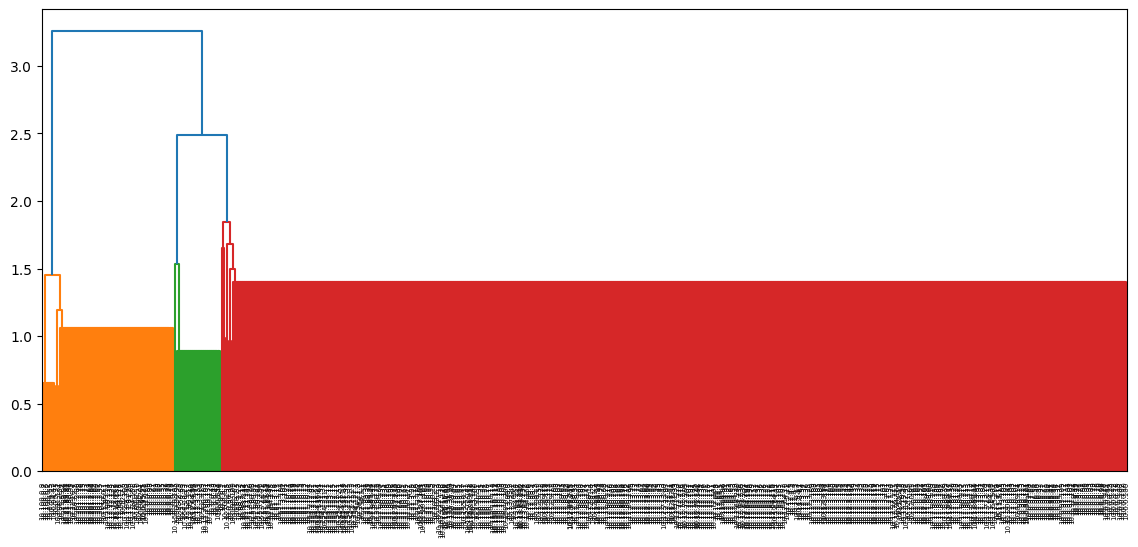

In [234]:
labelfile = f"timeseries_feature/pch/20230329/interval_{INTERVAL}_src_feature/rfcm_results.csv"
typefile = f"timeseries_feature/pch/20230329/interval_{INTERVAL}_src_feature/types.json"

print("\tLoading data...", " " * 50, end="\r", flush=True)

with open(typefile) as f:
    types = json.load(f)

df = pd.read_csv(labelfile, index_col=0, dtype=types)
df = df[df.index.str.startswith("10.")]

print("\tCalculating similarity matrix...", " " * 50, end="\r", flush=True)

cluster_sizes = [df.iloc[:, i].value_counts() for i in range(len(df.columns))]
number_entries = len(df.index)
number_features = len(df.columns)

def similarity_func(a, b):
    return np.sum([math.e ** -(5 * cluster_sizes[i][a[i]] / number_entries) for i in np.where(a == b)[0]], dtype=np.float16) / number_features

similarity_matrix = pd.DataFrame(squareform(pdist(df, similarity_func)) + np.identity(len(df.index)), index=df.index, columns=df.index)
dissimilarity_matrix = 1 - similarity_matrix

print("\tClustering...", " " * 50, flush=True)

Z = linkage(dissimilarity_matrix, 'complete')
dendrogram(Z, labels=df.index, orientation='top', leaf_rotation=90)

In [235]:
model = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='complete', distance_threshold=0.5)
labels = model.fit_predict(similarity_matrix)
result = pd.DataFrame(labels, index=df.index, columns=['cluster'])

In [236]:
result.to_csv("timeseries_feature/pch/20230329/interval_60_src_feature/rfcm_results_clustered.csv")

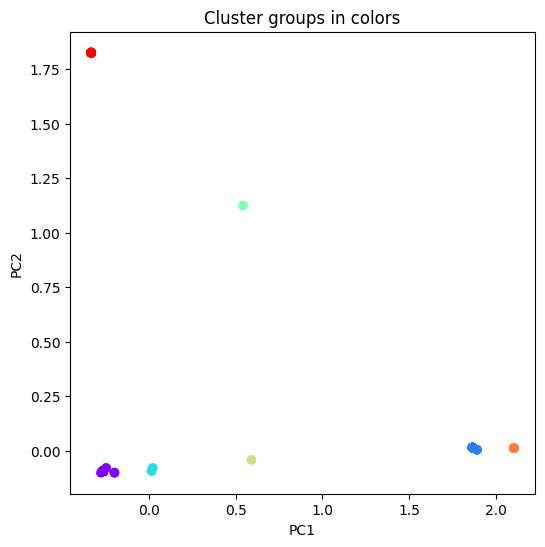

In [240]:
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(similarity_matrix)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']

ac2 = AgglomerativeClustering(n_clusters=7)

plt.figure(figsize =(6, 6))
plt.scatter(X_principal['P1'], X_principal['P2'], 
           c = ac2.fit_predict(X_principal), cmap ='rainbow')
plt.title('Cluster groups in colors')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [124]:
with open("timeseries/pch/20230329/interval_60_src_feature/pyts_dataset_feature.txt") as f:
    features = f.read().splitlines()
with open("timeseries/pch/20230329/interval_60_src_feature/pyts_dataset_sample.txt") as f:
    samples = f.read().splitlines()
ts = np.load("timeseries/pch/20230329/interval_60_src_feature/pyts_dataset.npy")

In [125]:
features

['packets',
 'bytes',
 'flows',
 'bytes/packets',
 'flows/(bytes/packets)',
 'nDstIP',
 'nSrcPort',
 'nDstPort']

In [123]:
ts.shape

(1973, 8, 1441)

In [241]:
result_pca = pd.DataFrame(ac2.labels_, index=df.index, columns=['cluster'])
result_pca.value_counts()

cluster
0          468
1           62
6           23
5            7
2            2
3            1
4            1
dtype: int64

In [239]:
result.value_counts()

cluster
4          149
1          134
5          107
6           62
2           52
0           34
3           26
dtype: int64

34 個節點，占 6.028368794326241


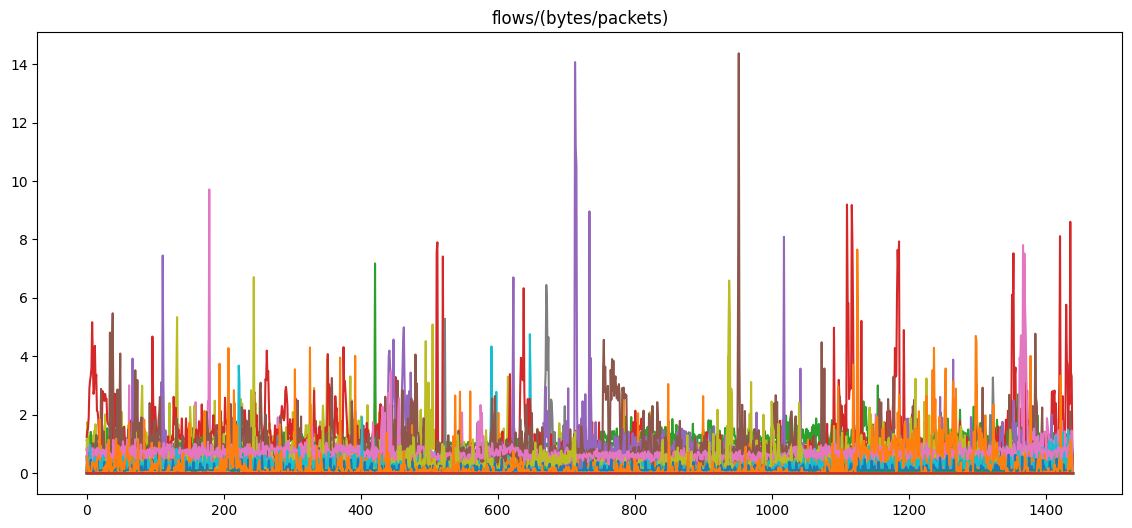

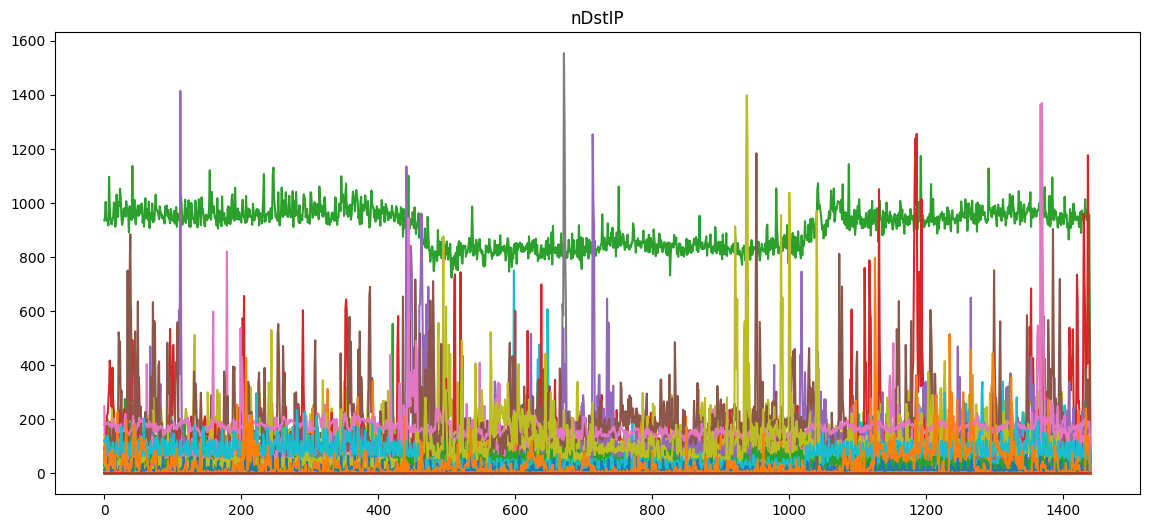

In [245]:
# 低活躍、雜亂使用
print(len(result[result["cluster"] == 0]), "個節點，占", len(result[result["cluster"] == 0]) / len(result) * 100)
for i in [4, 5]:
    for ip in result[result["cluster"] == 0].index:
        plt.plot(ts[samples.index(ip)][i])
    plt.title(features[i])
    plt.show()
    # plt.plot(ts[samples.index(ip)][7])
    # plt.title(ip)
    # plt.show()

134 個節點，占 23.75886524822695


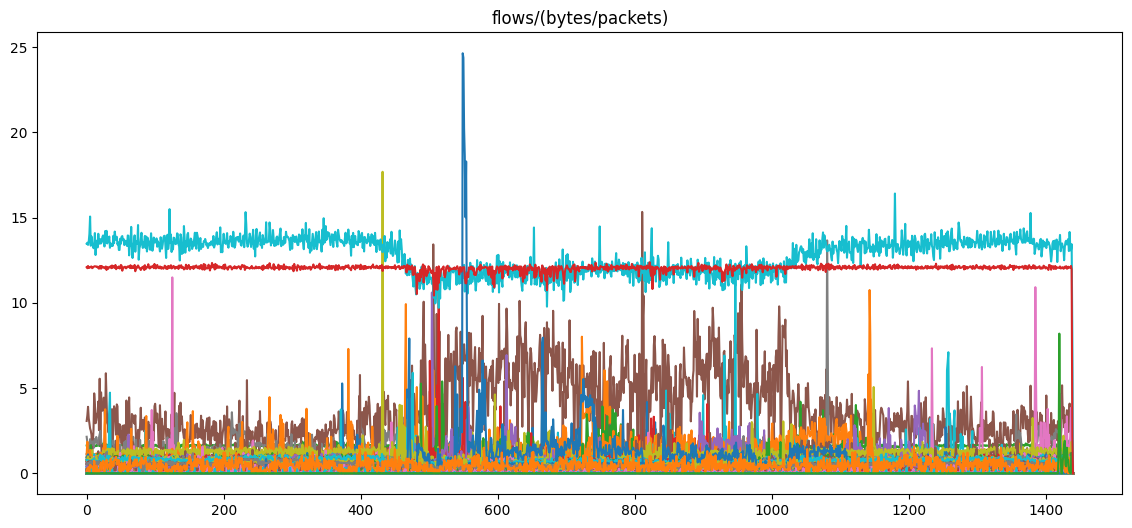

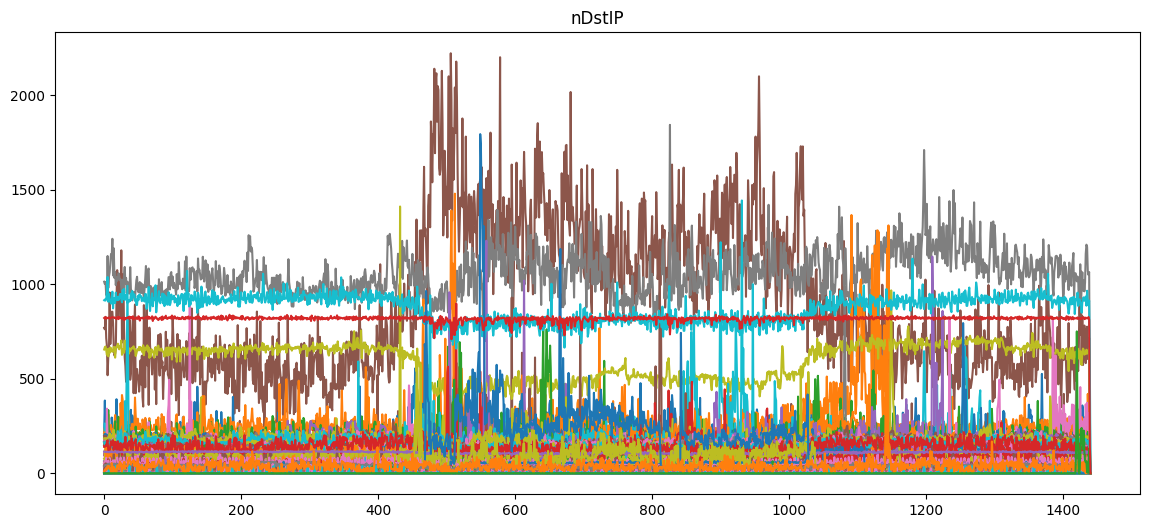

In [246]:
# 看起來像是偶爾爆炸性的活躍
print(len(result[result["cluster"] == 1]), "個節點，占", len(result[result["cluster"] == 1]) / len(result) * 100)
for i in [4, 5]:
    for ip in result[result["cluster"] == 1].index:
        plt.plot(ts[samples.index(ip)][i])
    plt.title(features[i])
    plt.show()
    # plt.title(ip)
    # plt.show()

52 個節點，占 9.219858156028367


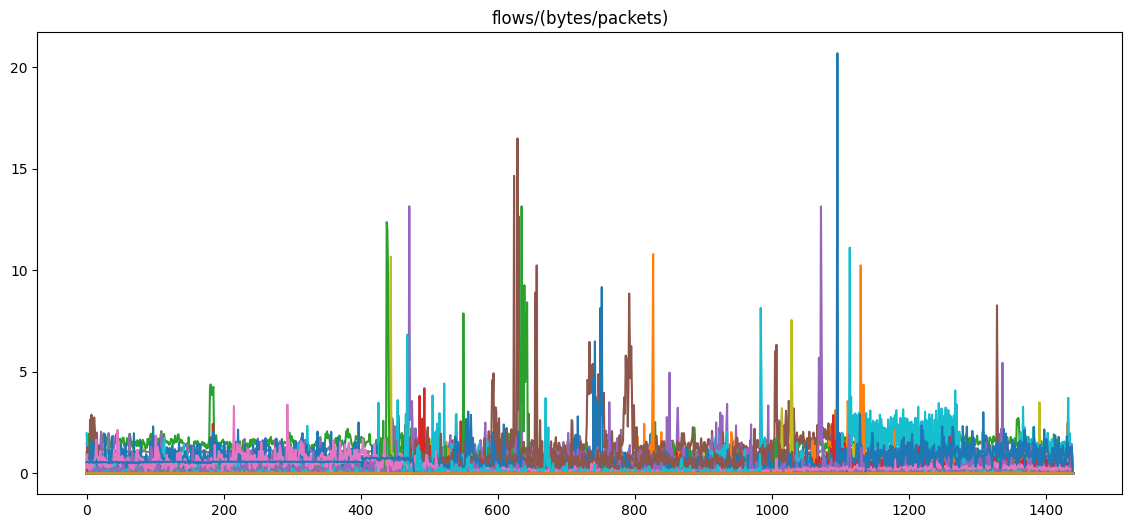

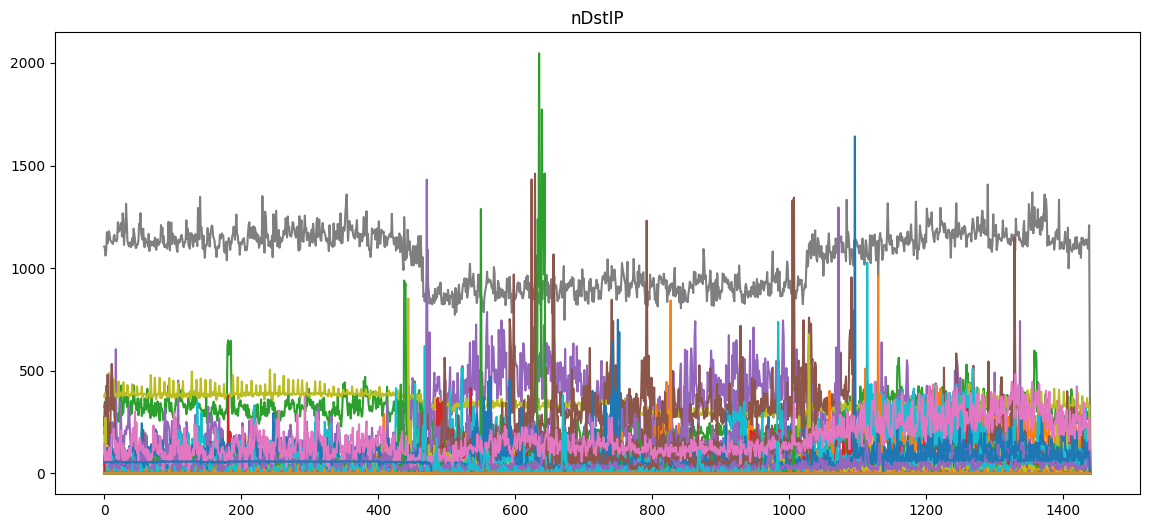

In [247]:
# 看起來像是穩定的低度活躍，但上班時間小小低落
print(len(result[result["cluster"] == 2]), "個節點，占", len(result[result["cluster"] == 2]) / len(result) * 100)
for i in [4, 5]:
    for ip in result[result["cluster"] == 2].index:
        plt.plot(ts[samples.index(ip)][i])
    plt.title(features[i])
    plt.show()
    # plt.title(ip)
    # plt.show()

26 個節點，占 4.609929078014184


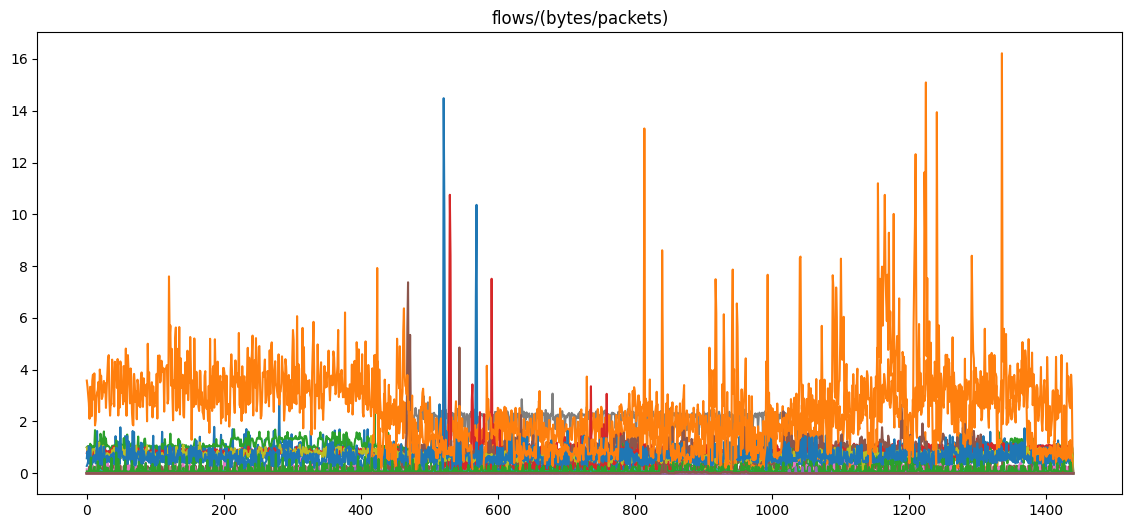

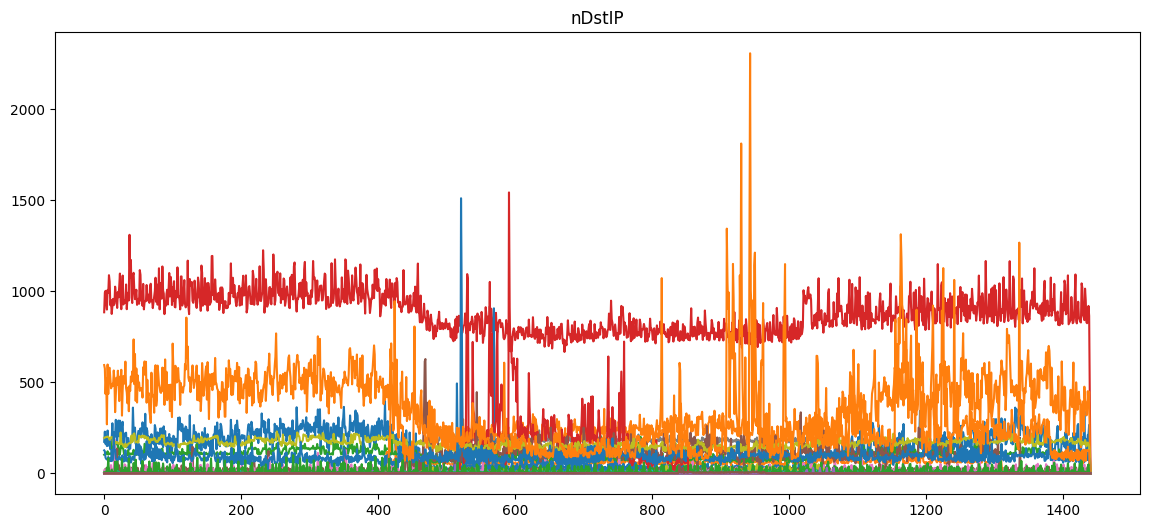

In [248]:
# 31 個節點 5.4232%
# 看起來像是穩定的低度活躍，上班時間偶爾出現爆炸性活躍
print(len(result[result["cluster"] == 3]), "個節點，占", len(result[result["cluster"] == 3]) / len(result) * 100)
for i in [4, 5]:
    for ip in result[result["cluster"] == 3].index:
        plt.plot(ts[samples.index(ip)][i])
    plt.title(features[i])
    plt.show()
    # plt.title(ip)
    # plt.show()

149 個節點，占 26.418439716312058


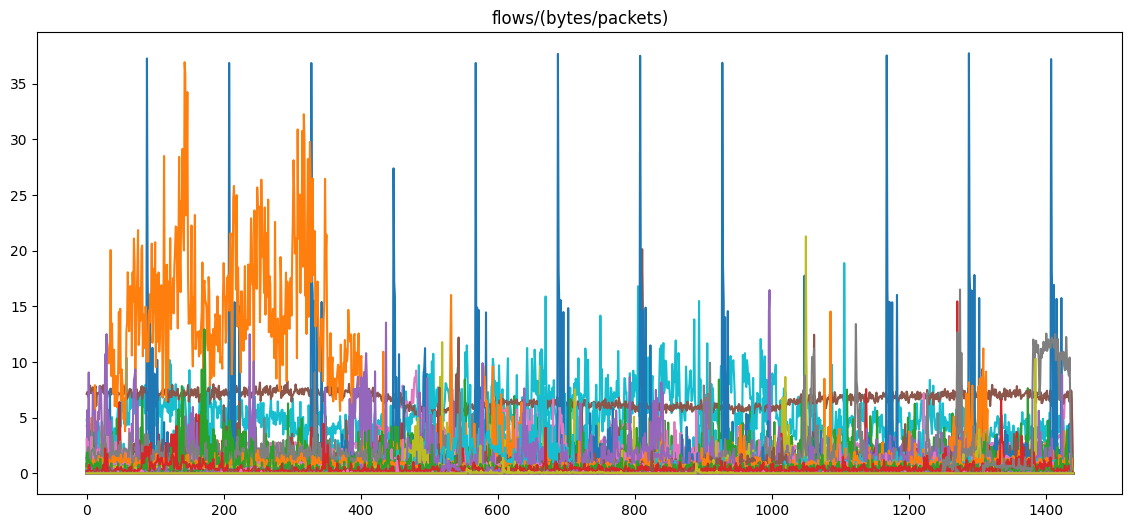

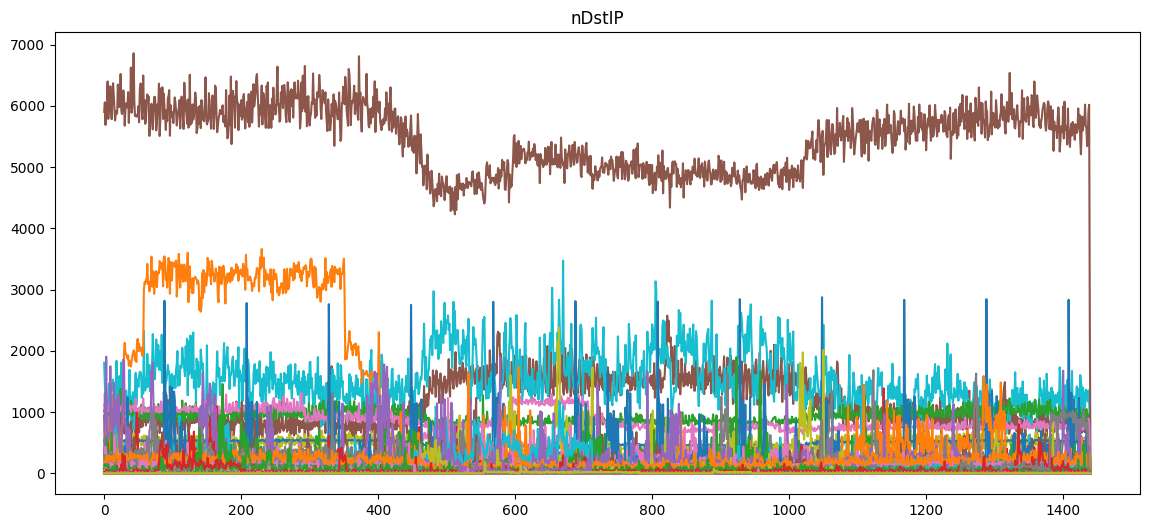

In [249]:
# 90 個節點 15.8135%
# 雜亂的使用
print(len(result[result["cluster"] == 4]), "個節點，占", len(result[result["cluster"] == 4]) / len(result) * 100)
for i in [4, 5]:
    for ip in result[result["cluster"] == 4].index:
        plt.plot(ts[samples.index(ip)][i])
    plt.title(features[i])
    plt.show()

107 個節點，占 18.97163120567376


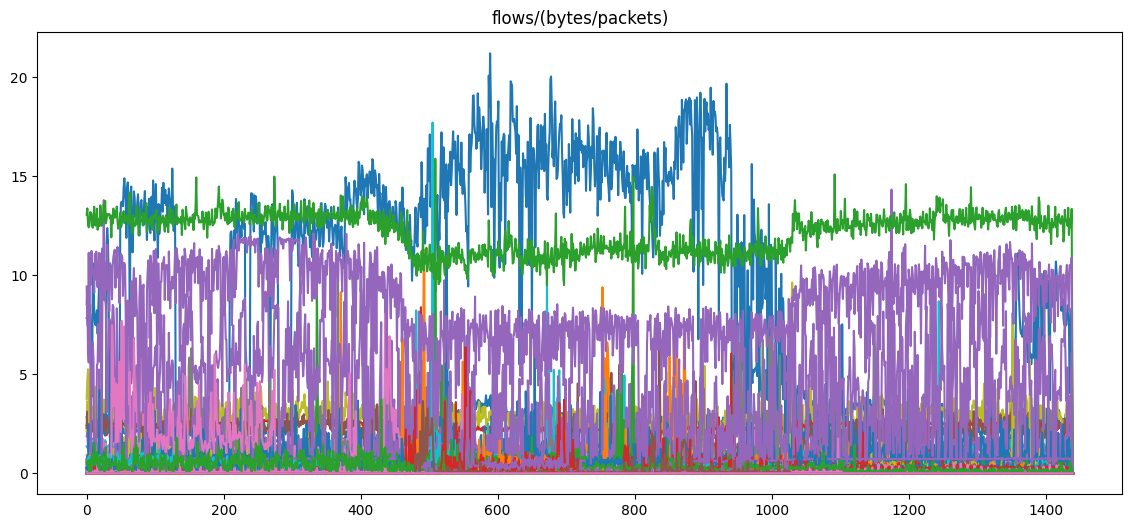

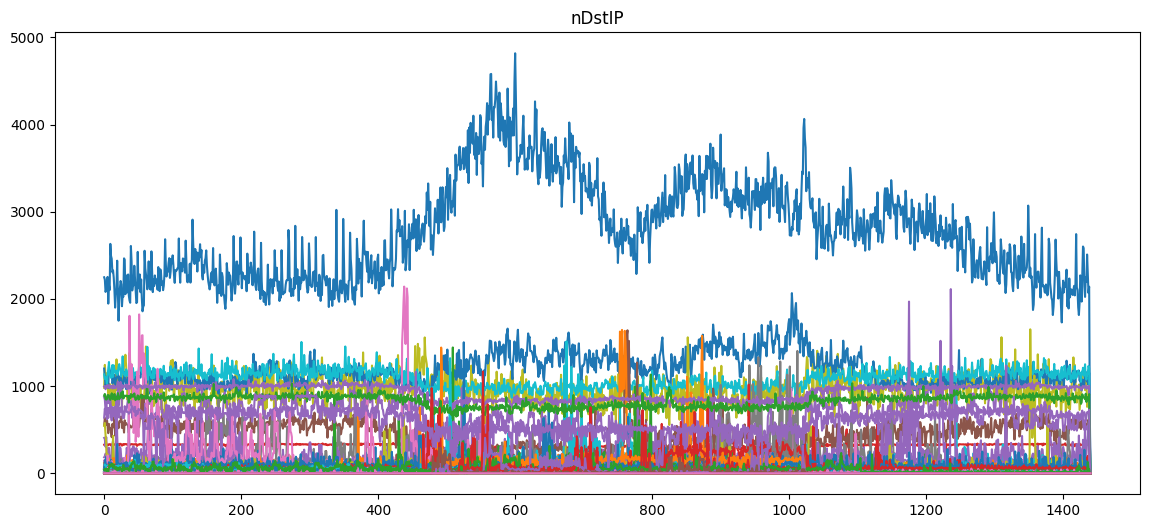

In [250]:
# 210 個節點 37.8611%
# 雜亂的使用者，但上班時間有一些小小的低落
print(len(result[result["cluster"] == 5]), "個節點，占", len(result[result["cluster"] == 5]) / len(result) * 100)
for i in [4, 5]:
    for ip in result[result["cluster"] == 5].index:
        plt.plot(ts[samples.index(ip)][i])
    plt.title(features[i])
    plt.show()

62 個節點，占 10.99290780141844


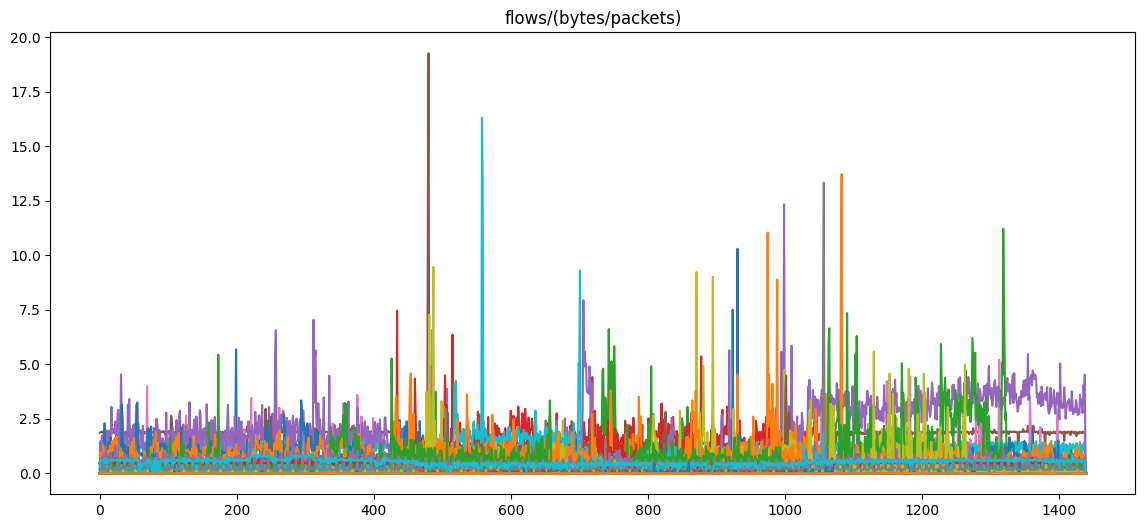

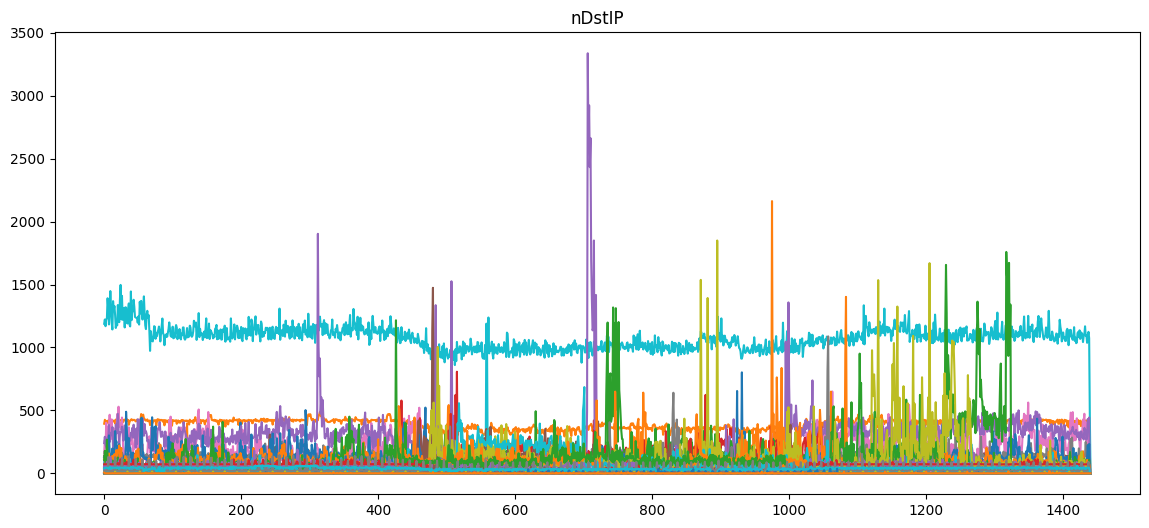

In [251]:
# 17 個節點
# 穩定的低度活躍，但上班時間有一些小小的低落
print(len(result[result["cluster"] == 6]), "個節點，占", len(result[result["cluster"] == 6]) / len(result) * 100)
for i in [4, 5]:
    for ip in result[result["cluster"] == 6].index:
        plt.plot(ts[samples.index(ip)][i])
    plt.title(features[i])
    plt.show()

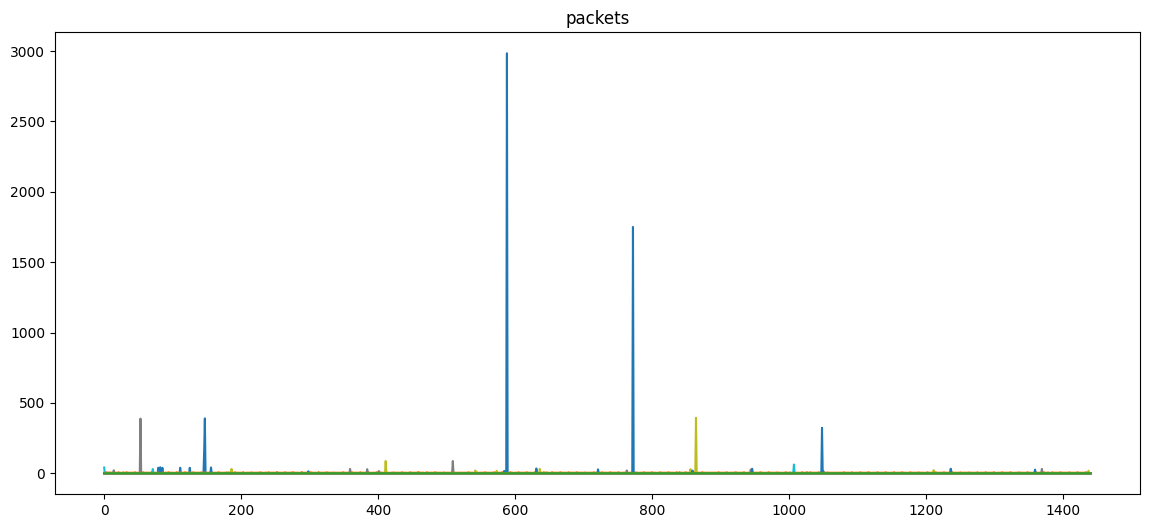

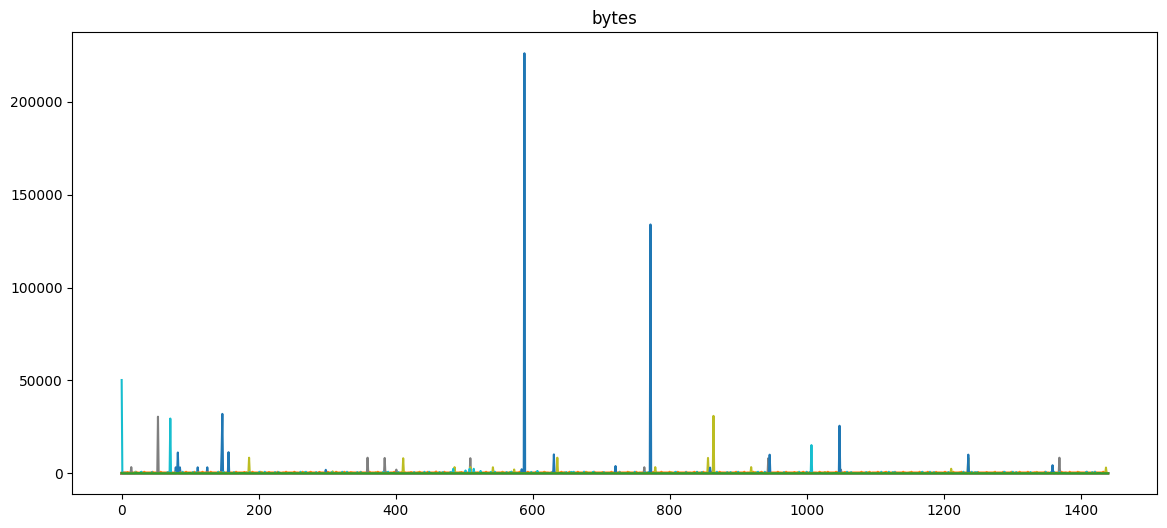

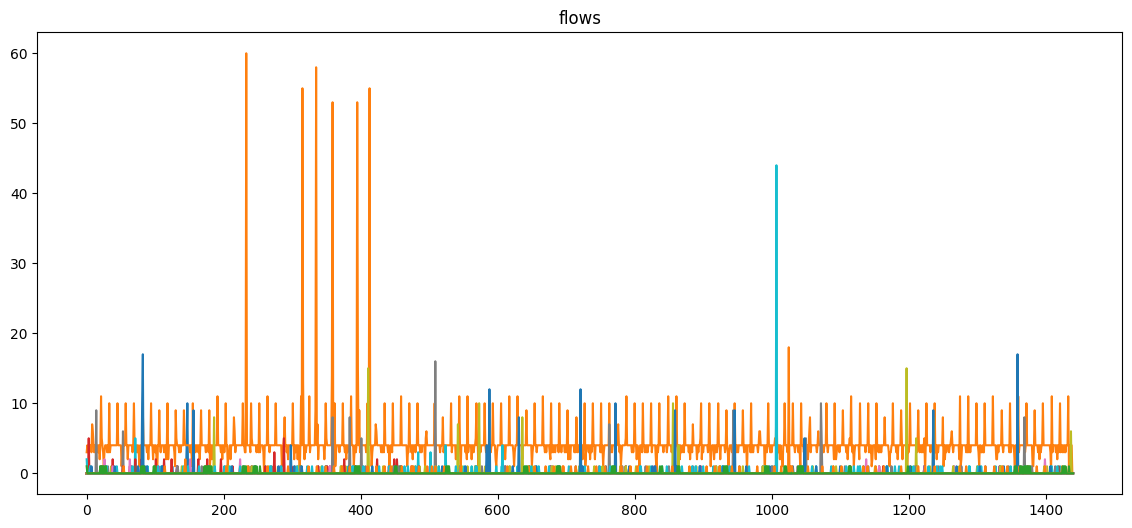

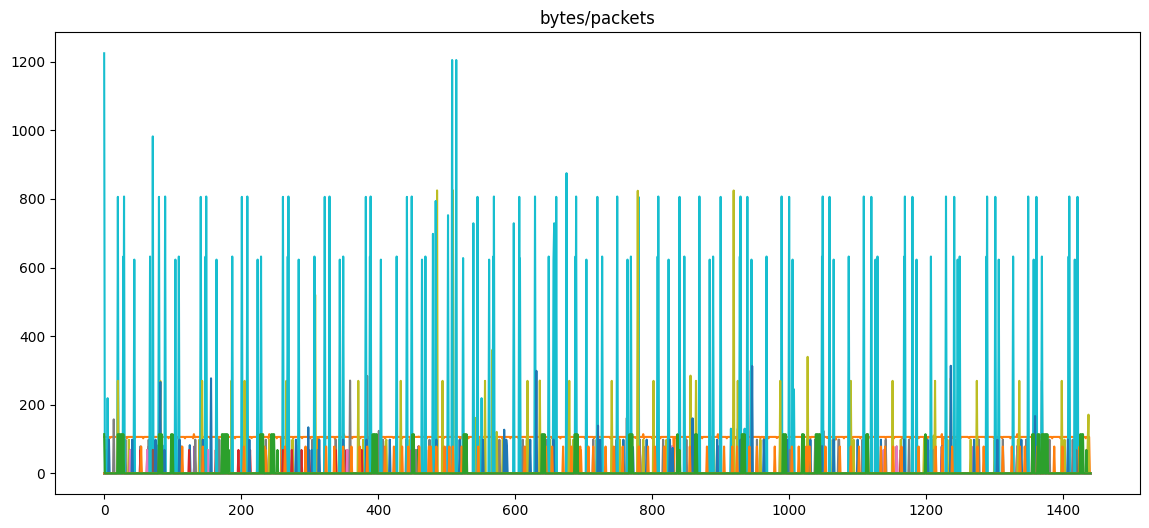

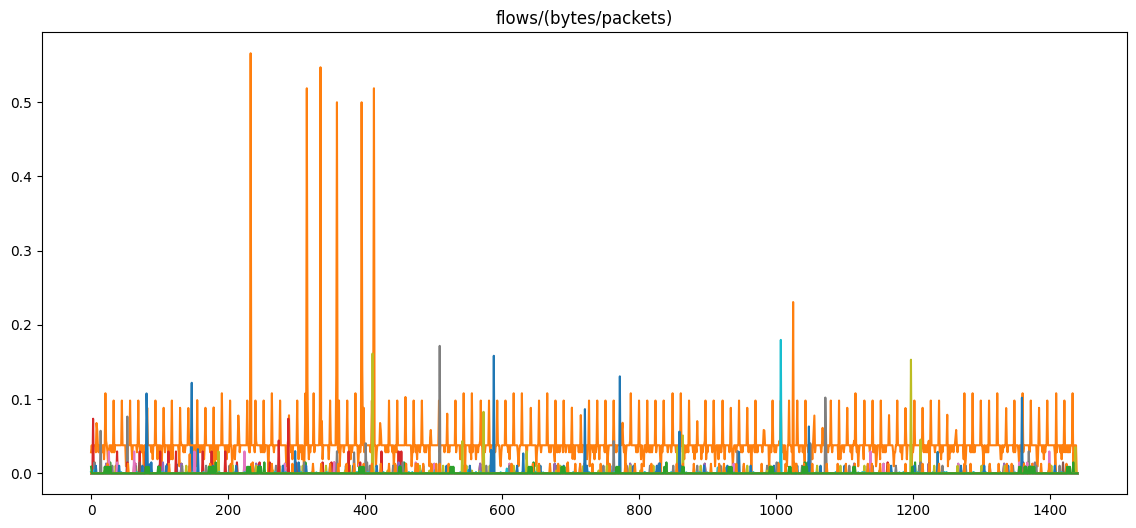

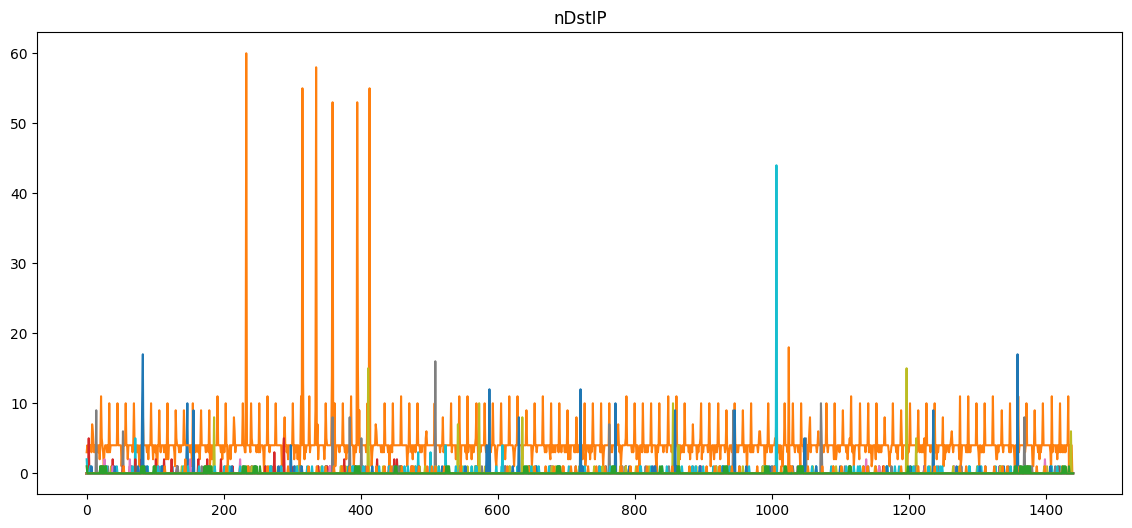

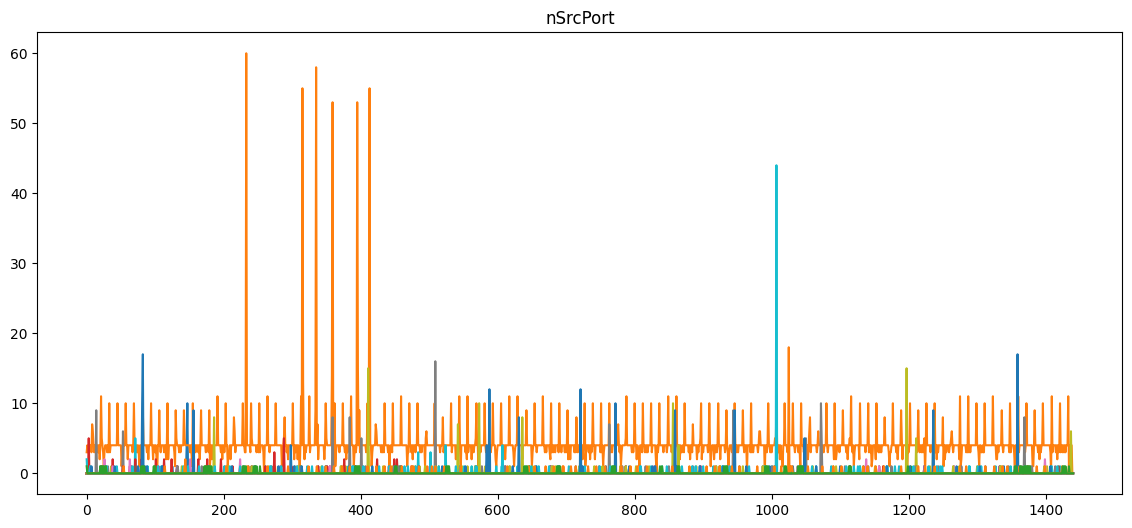

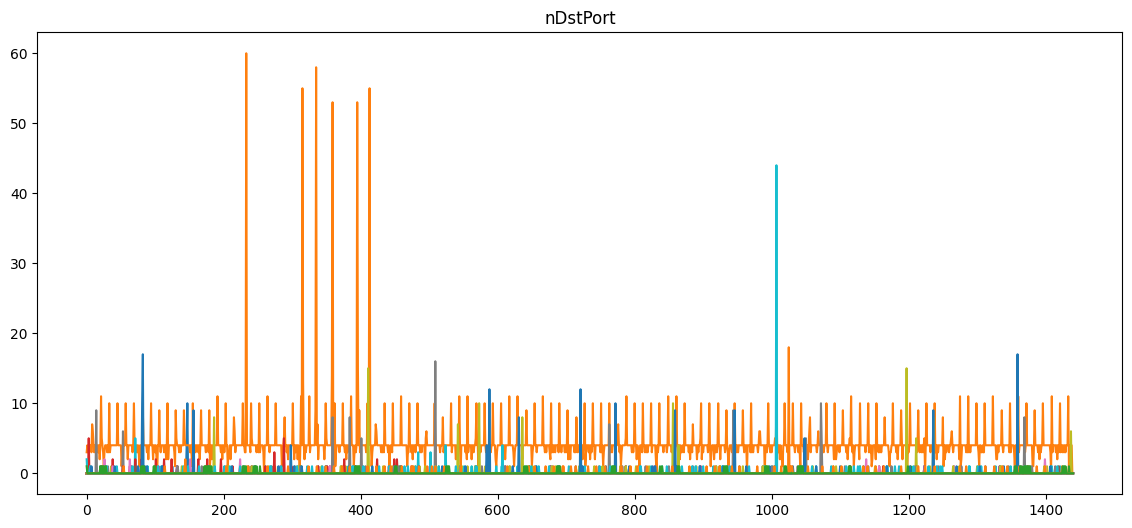

In [230]:
# 288 個節點
# 上班期間出現高度活躍
for i in range(len(features)):
    for ip in result_pca[(result_pca.index.str.startswith("10.")) & (result_pca["cluster"] == 7)].index:
        plt.plot(ts[samples.index(ip)][i])
    plt.title(features[i])
    plt.show()

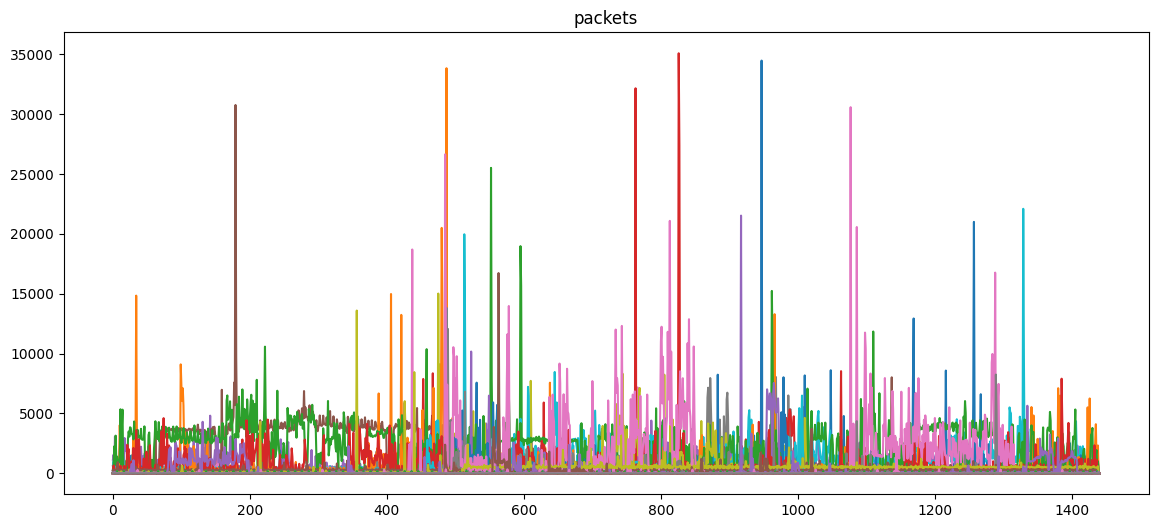

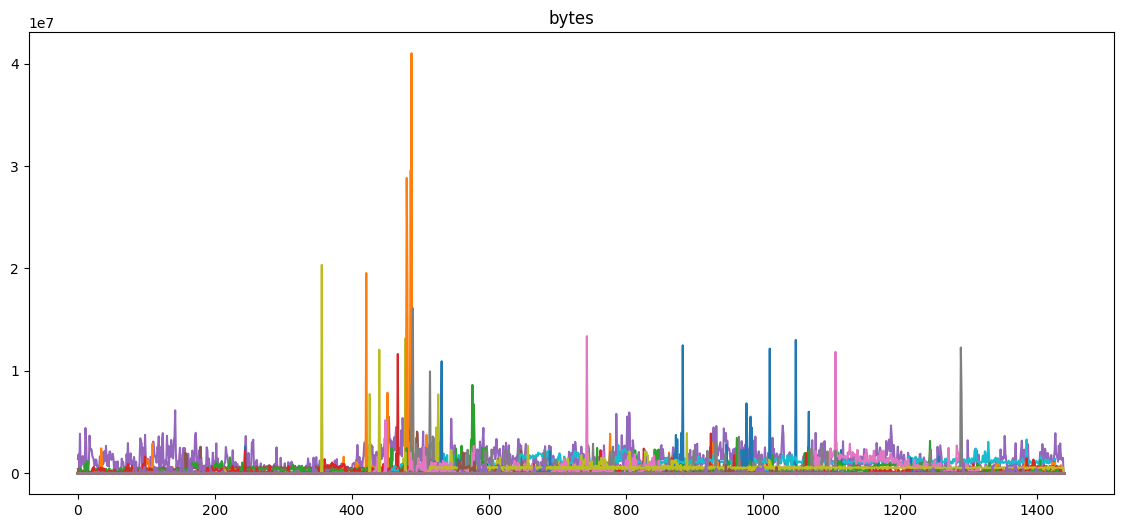

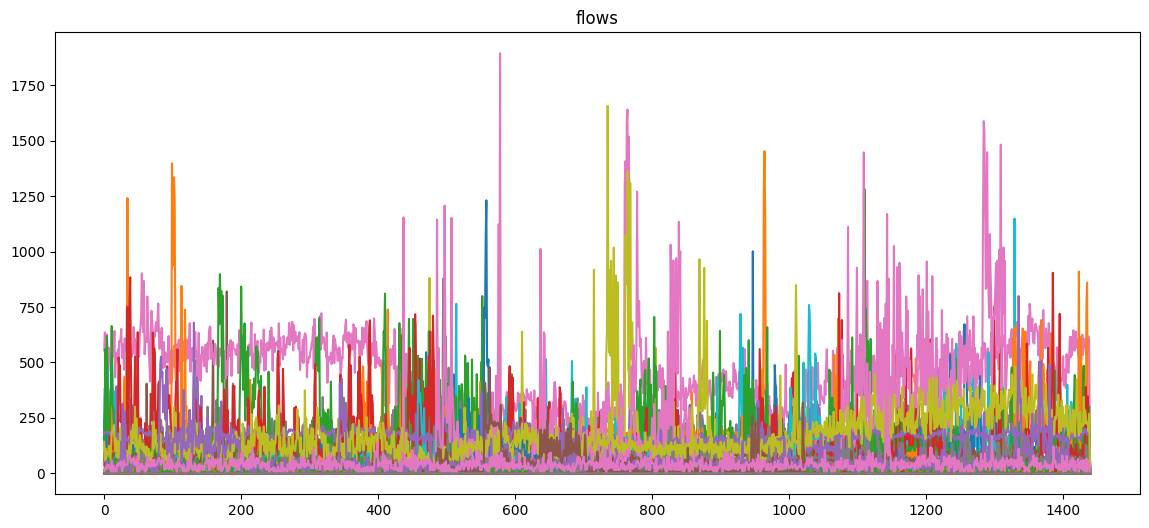

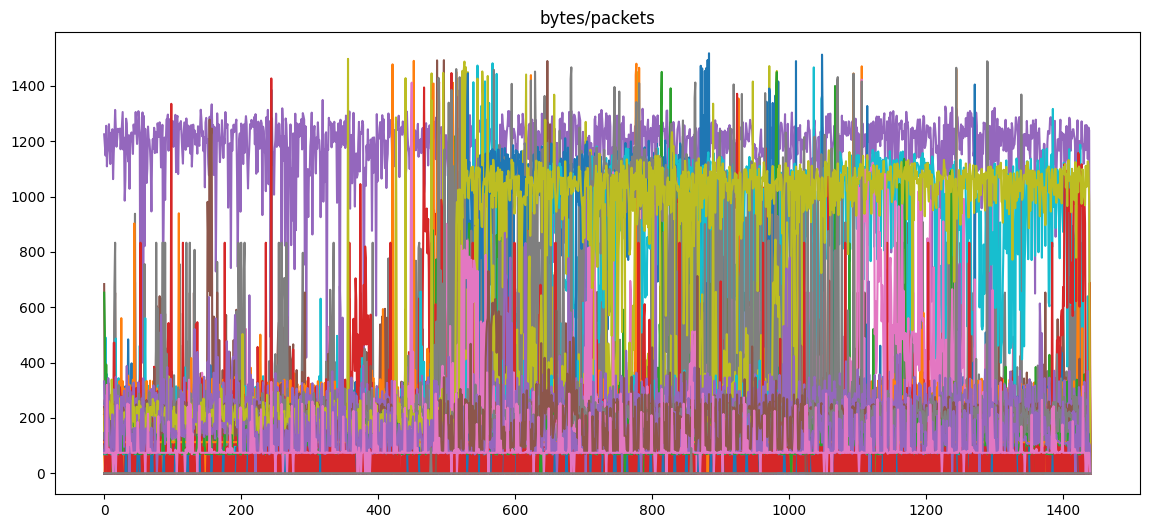

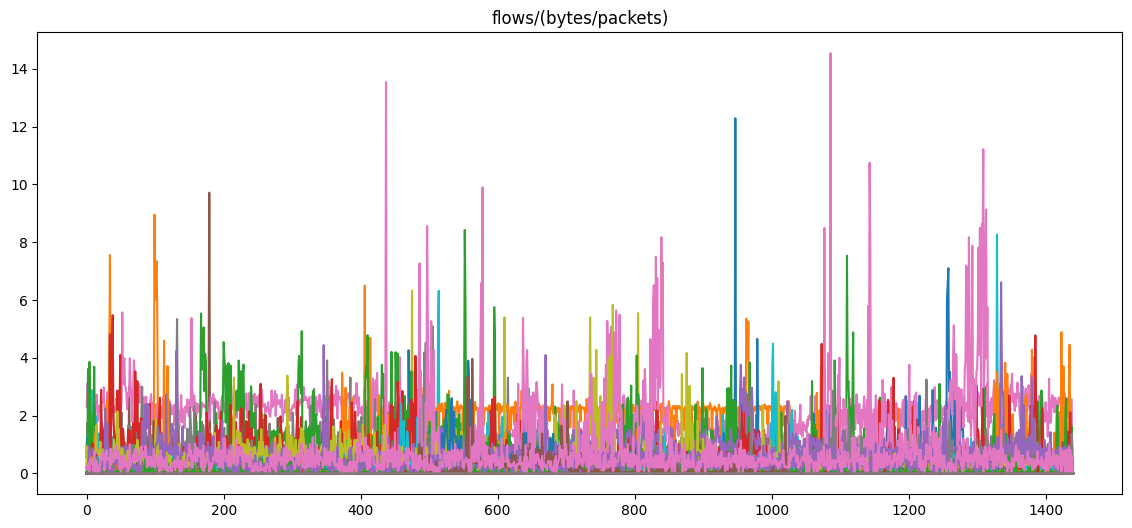

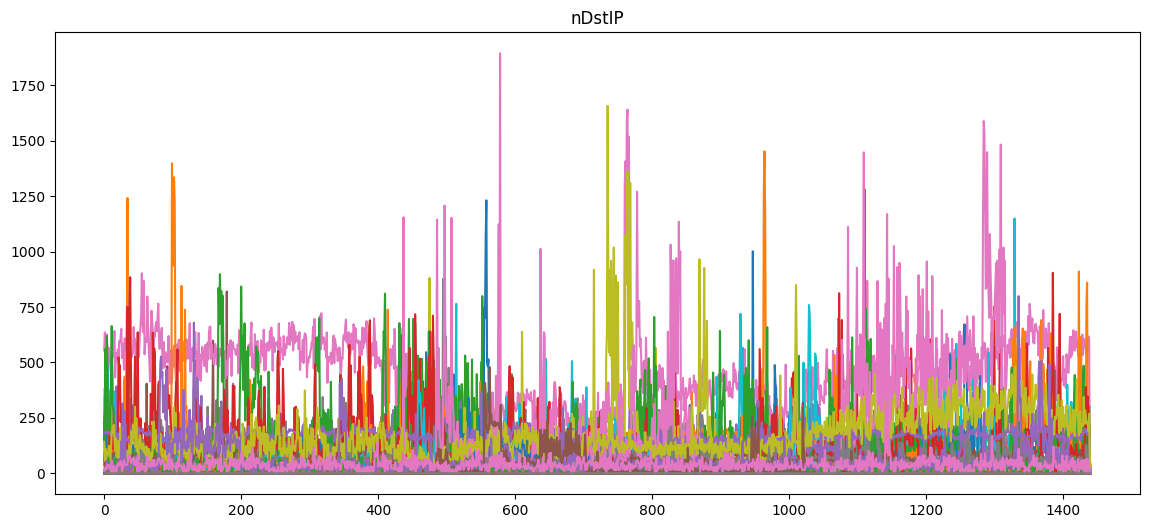

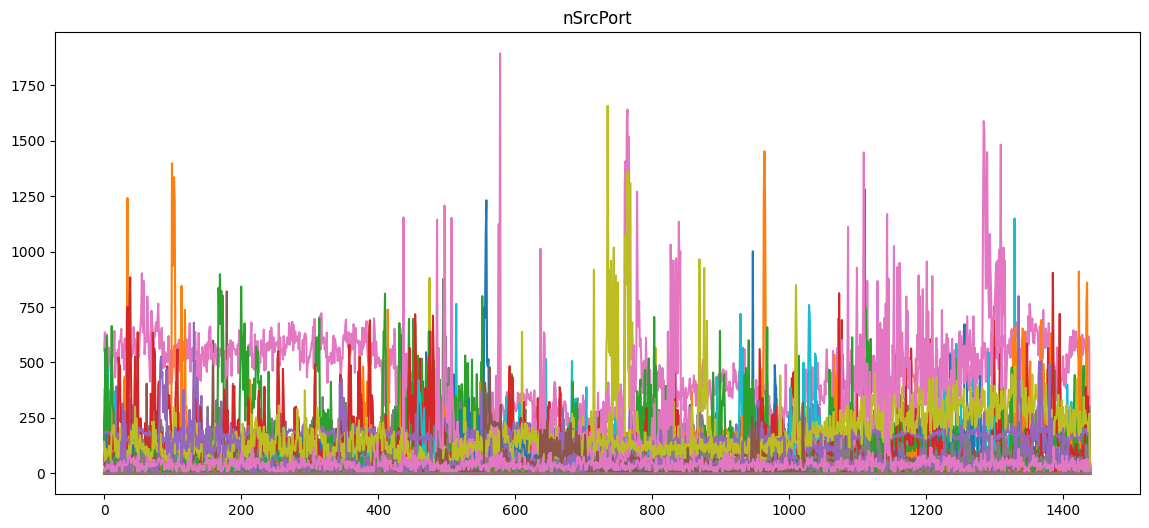

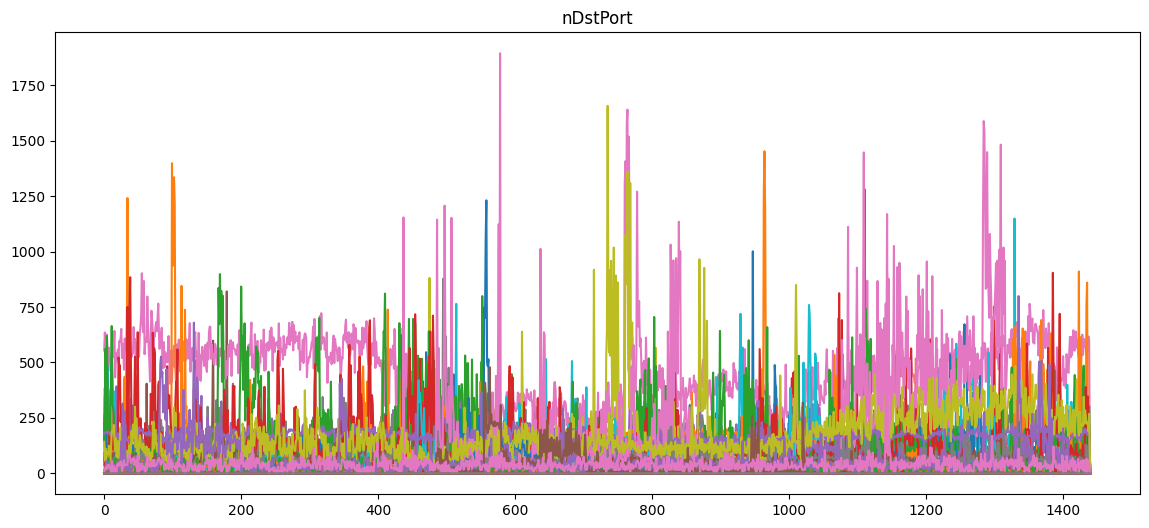

In [232]:
# 185 個節點
# 隨時活躍的雜亂使用
for i in range(len(features)):
    for ip in result[(result.index.str.startswith("10.")) & (result["cluster"] == 8)].index:
        if ip in ["10.100.0.1", "10.0.95.109", "10.0.95.60", "10.100.0.1", "10.100.0.10"]:
            continue
        plt.plot(ts[samples.index(ip)][i])
    plt.title(features[i])
    plt.show()

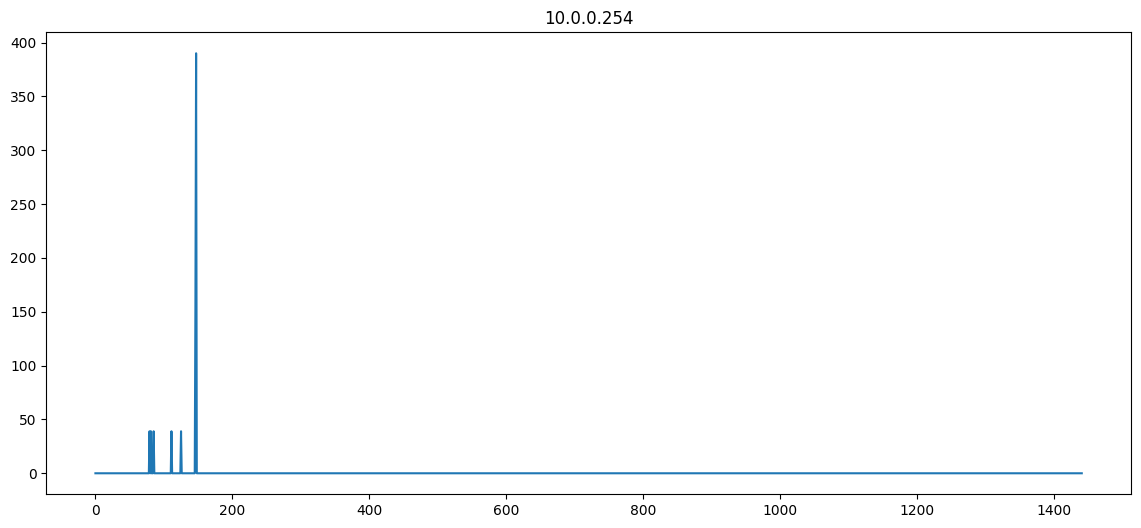

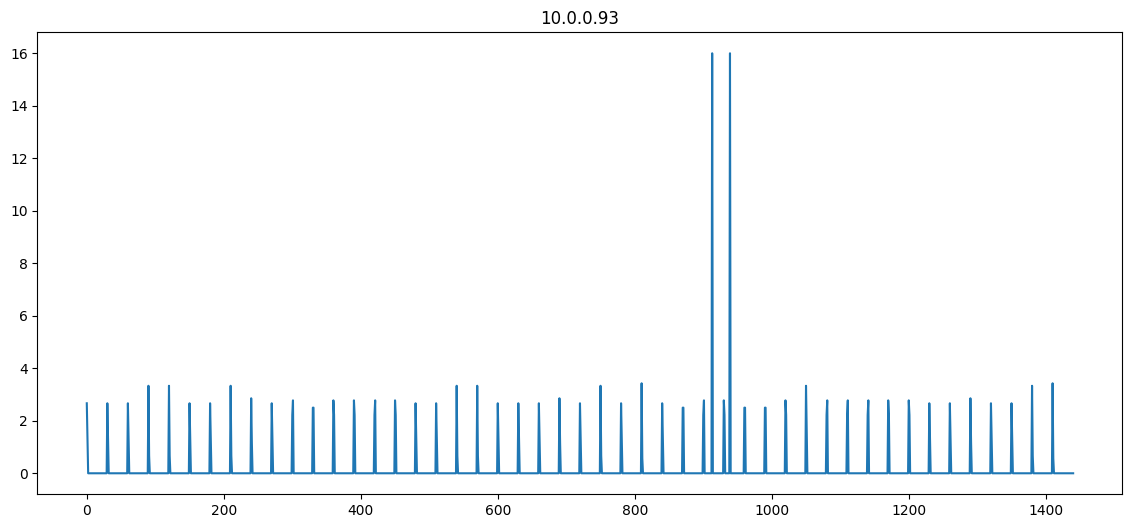

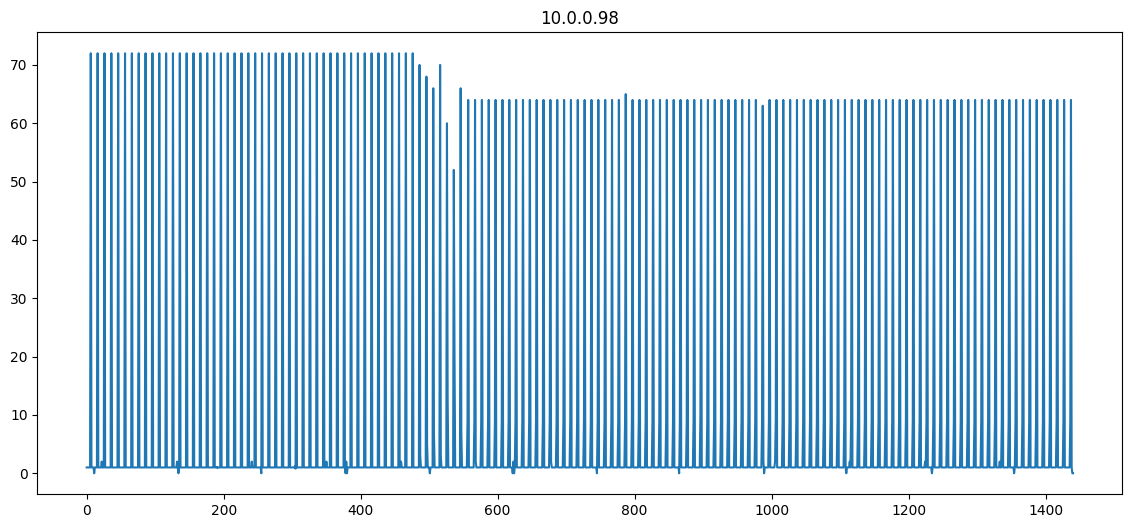

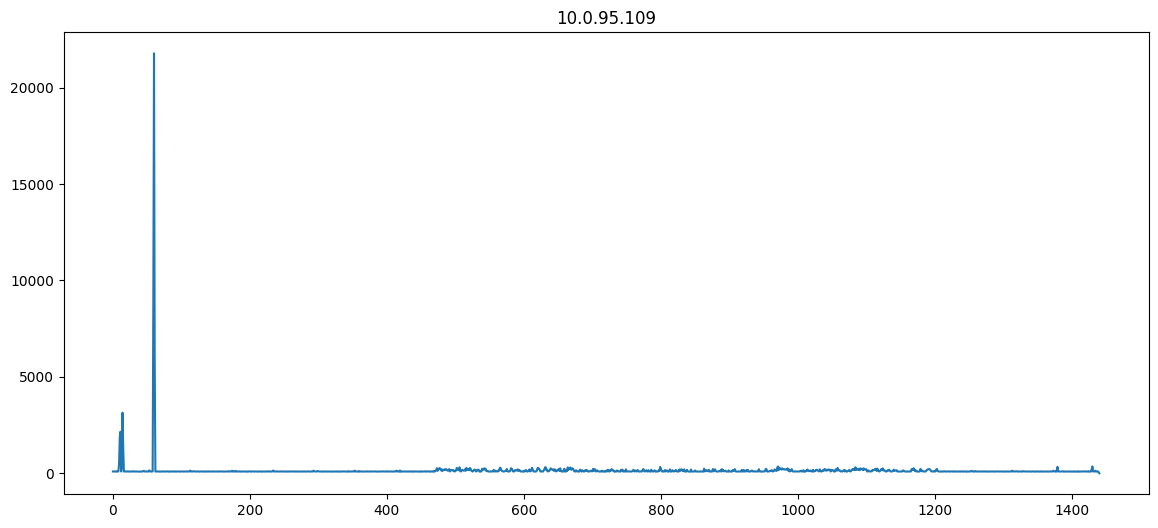

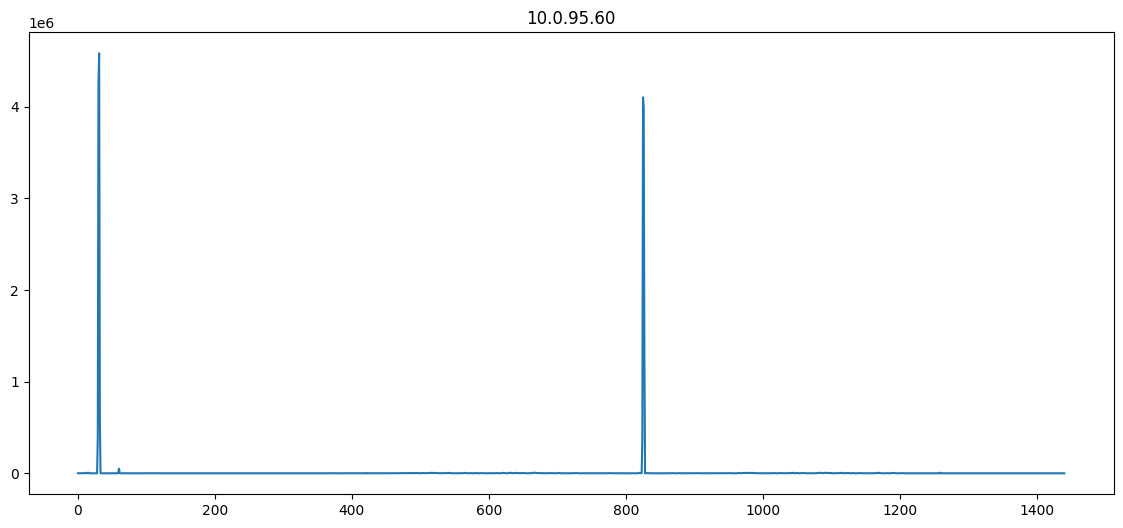

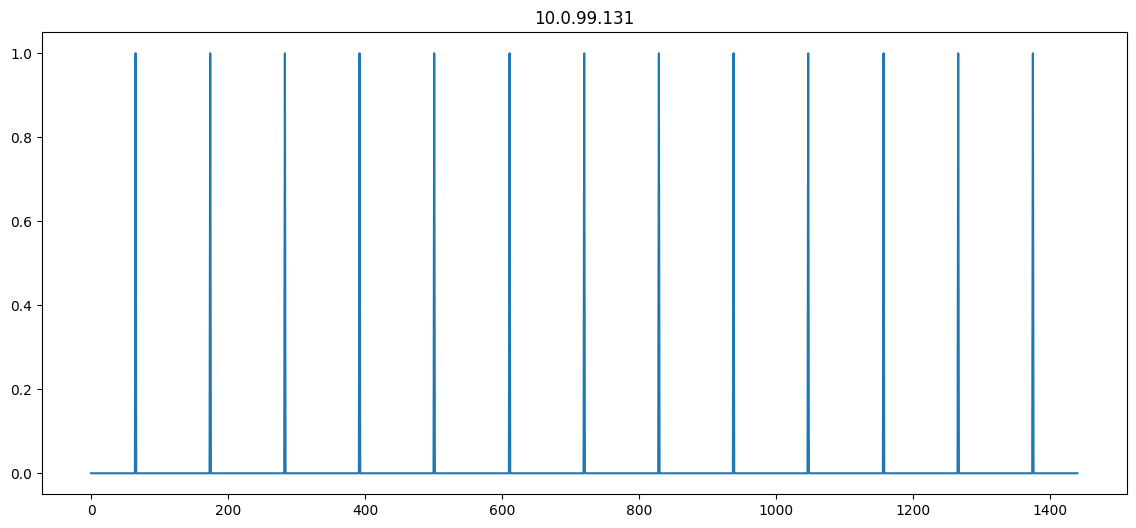

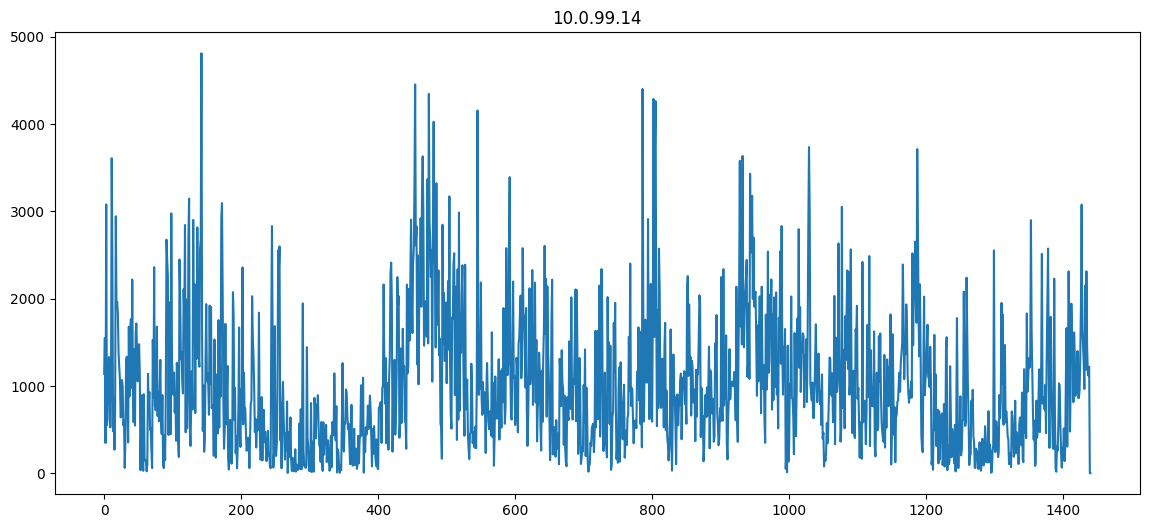

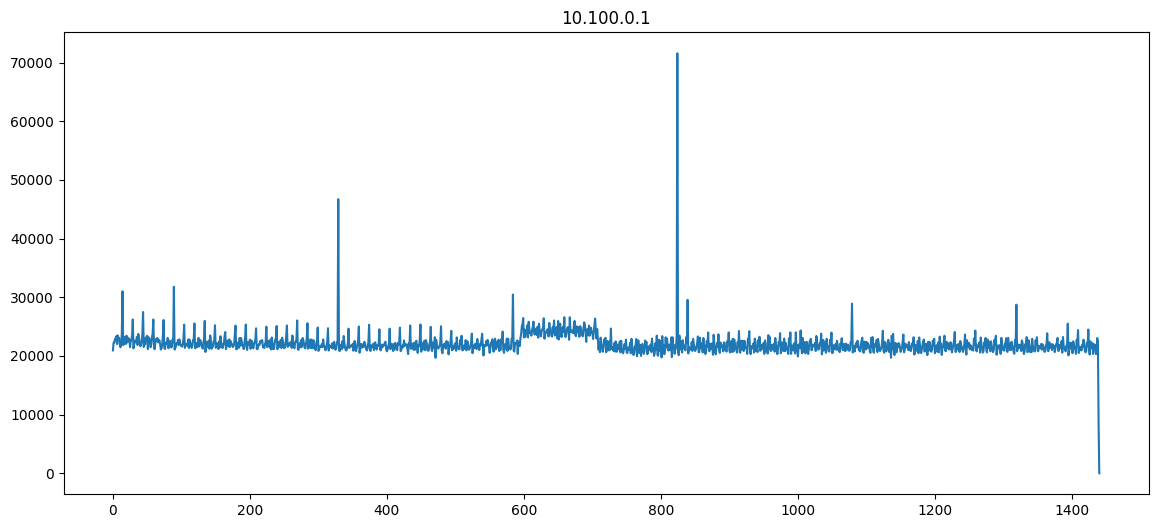

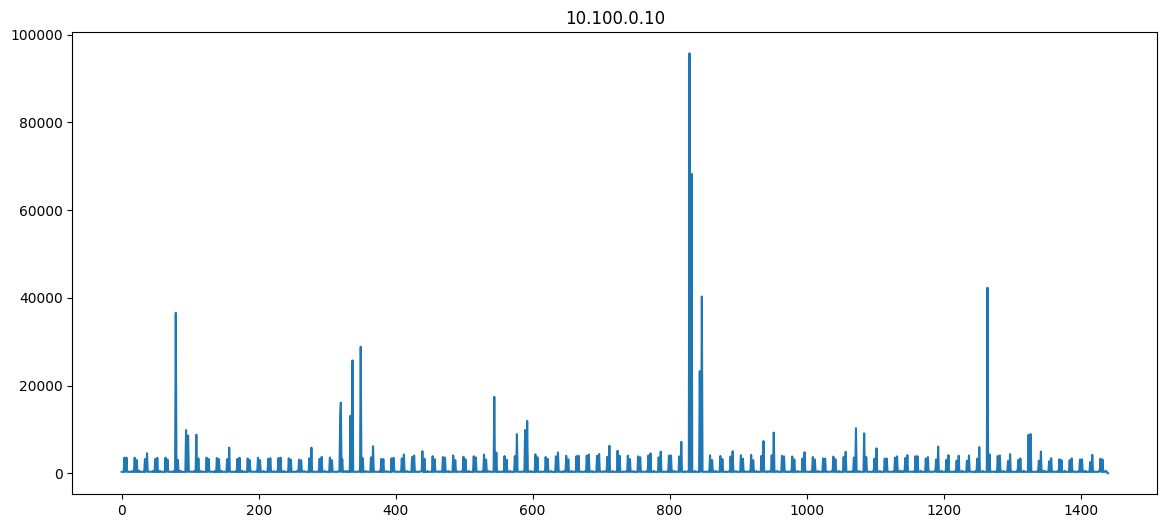

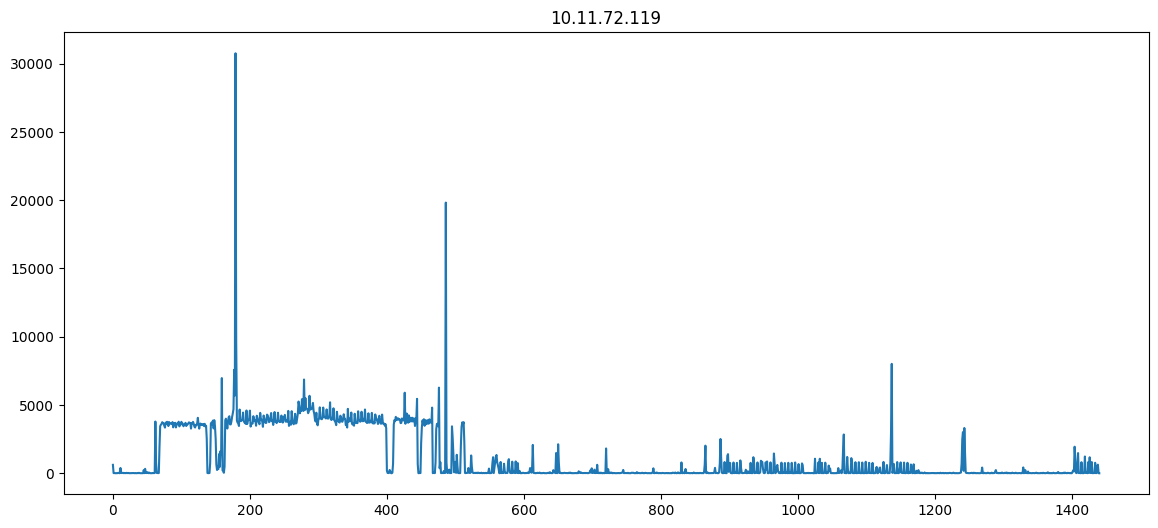

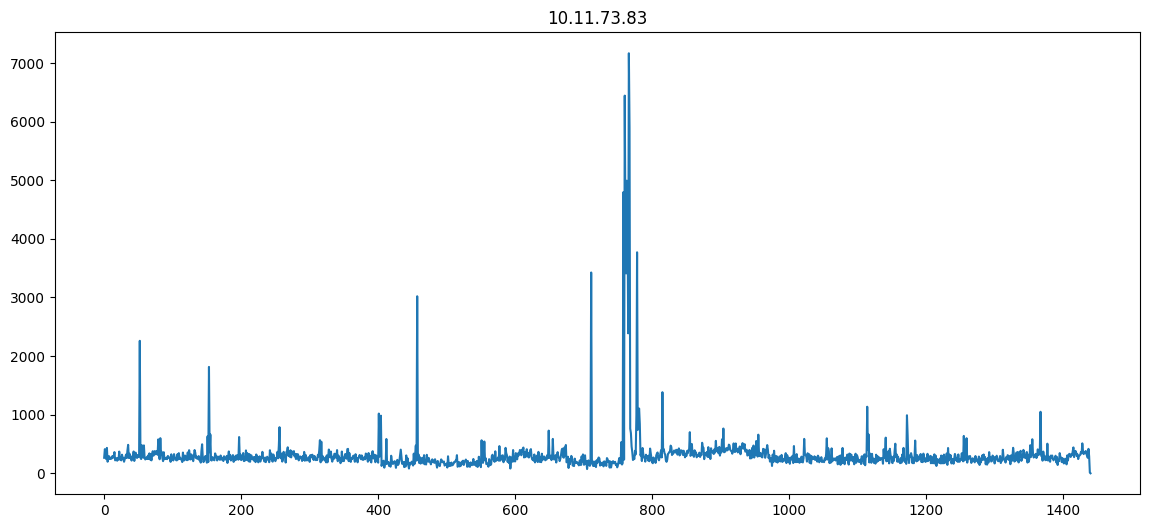

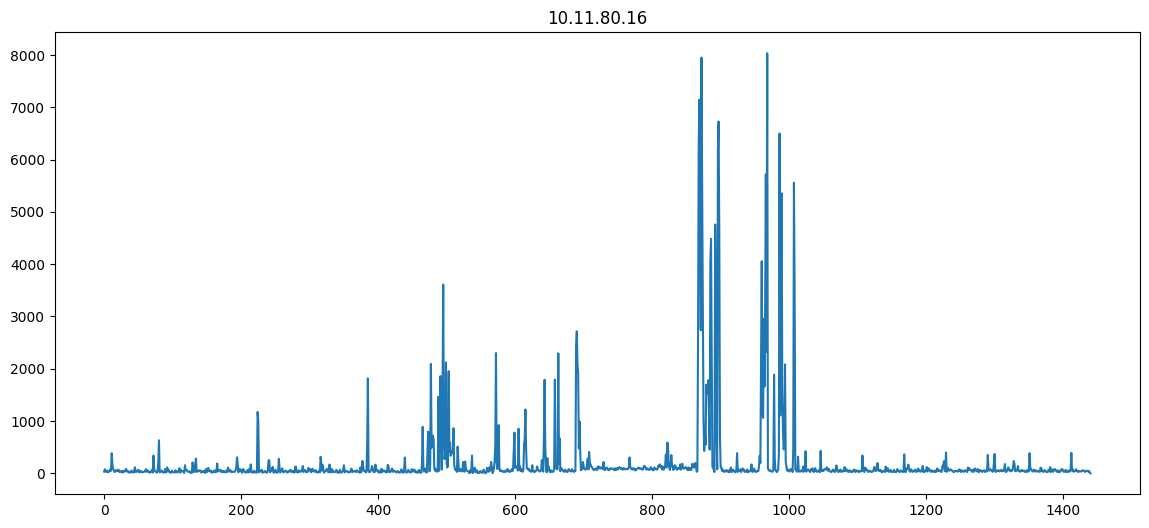

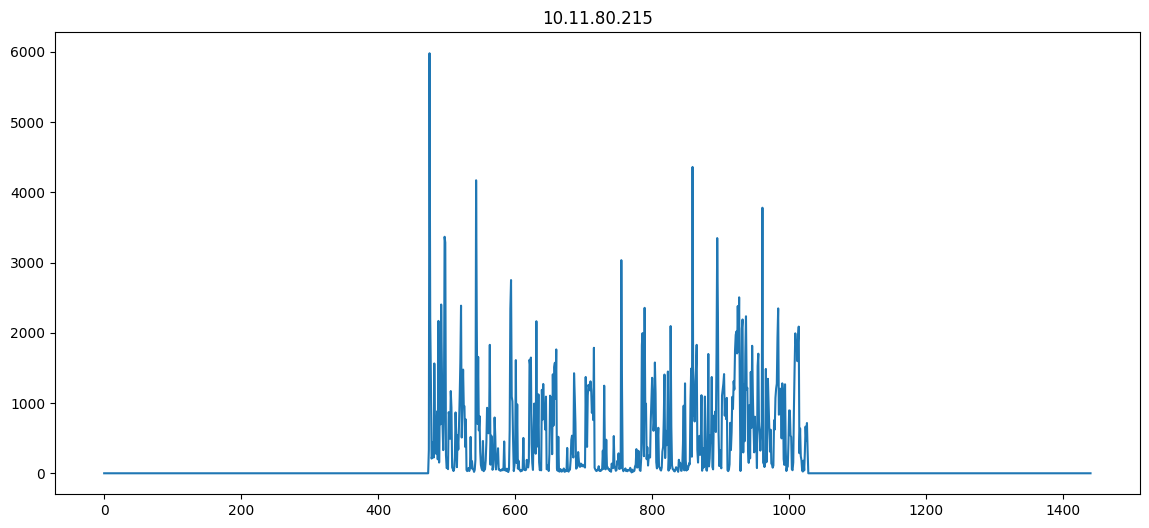

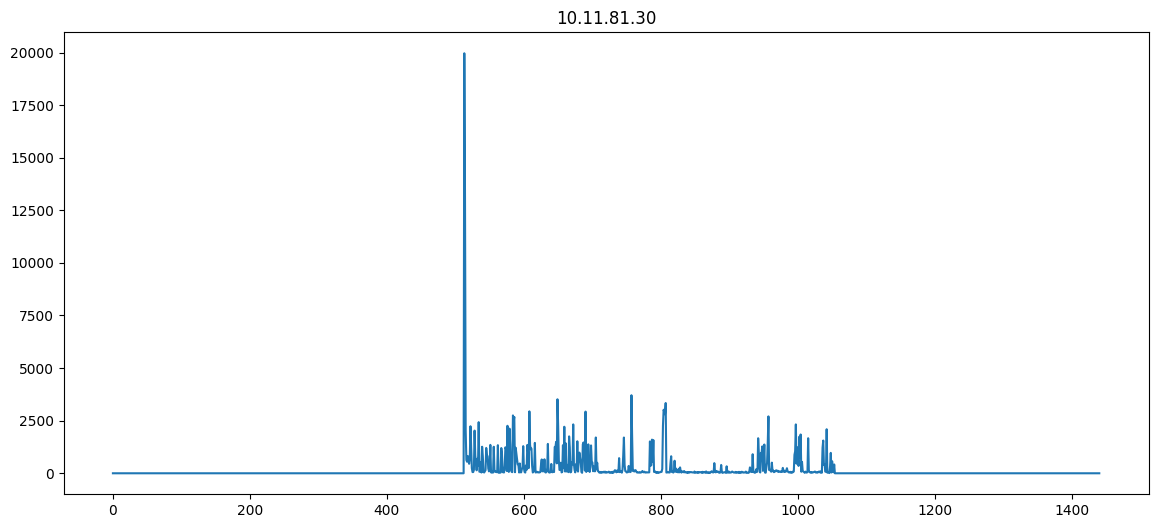

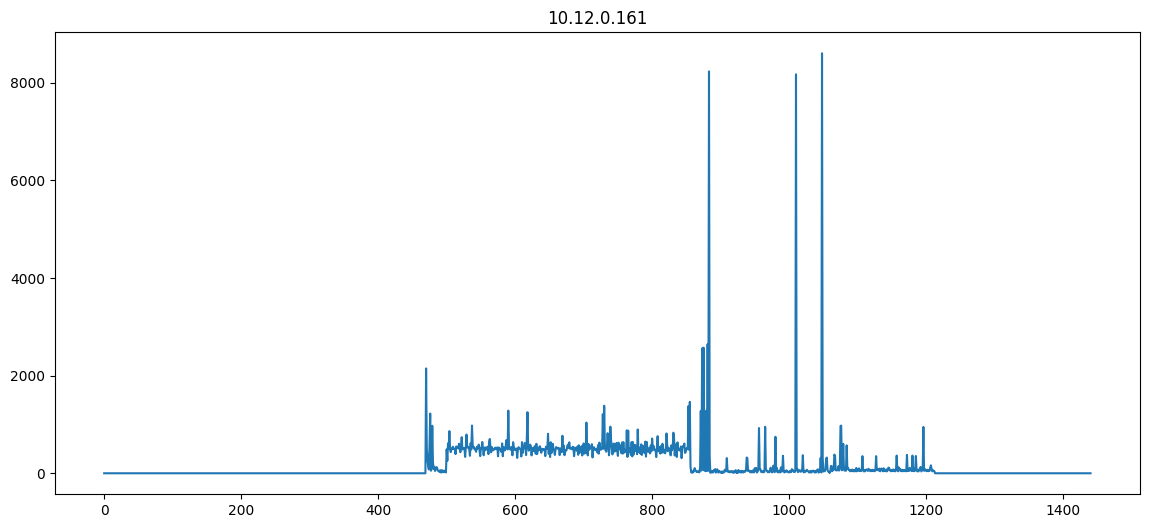

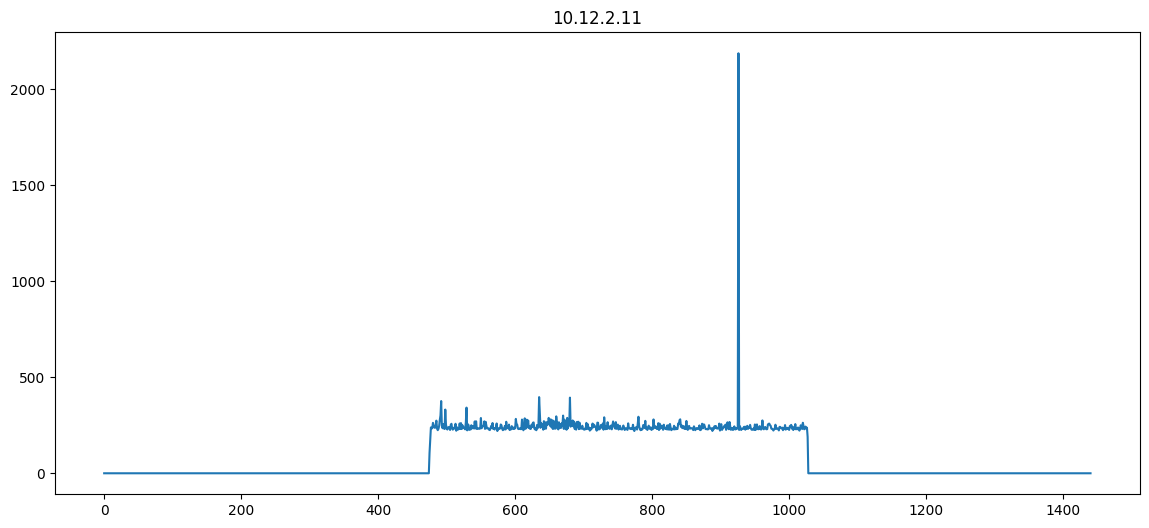

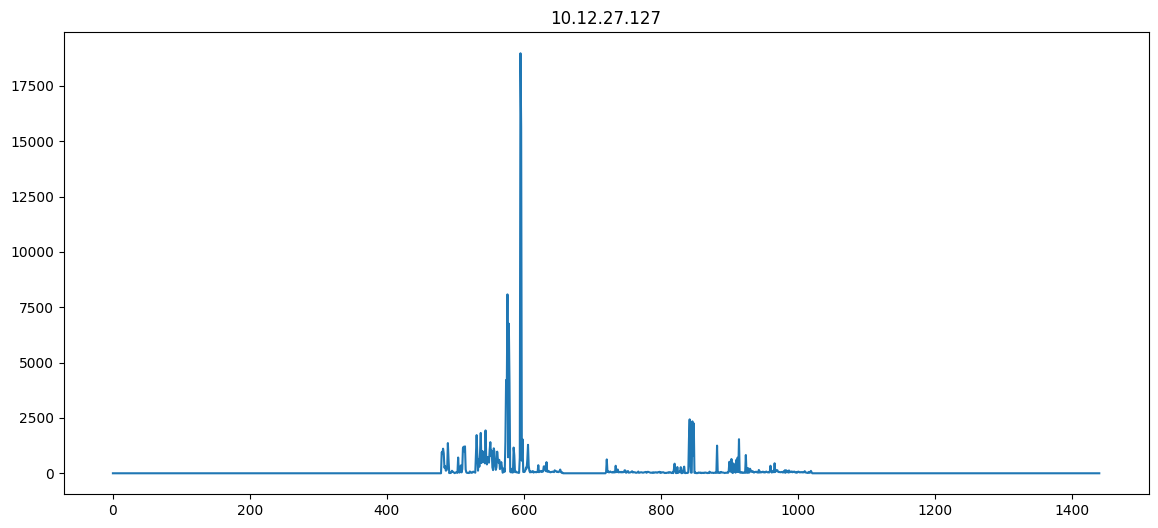

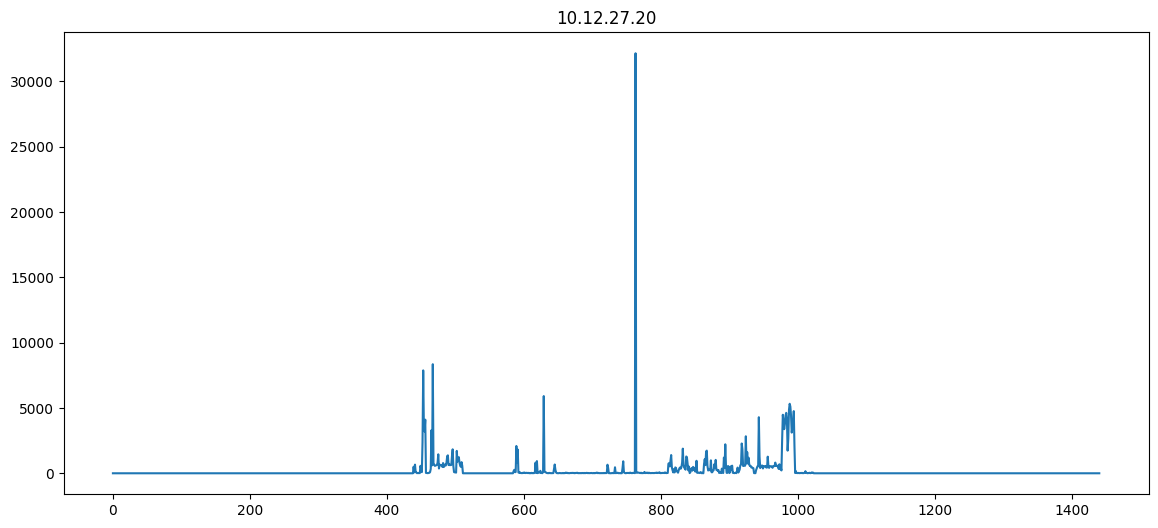

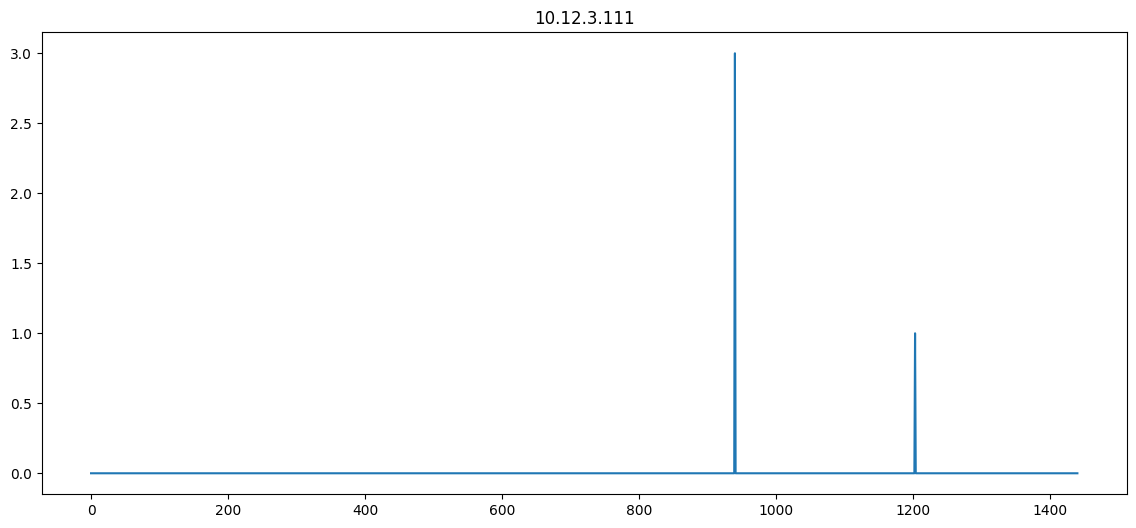

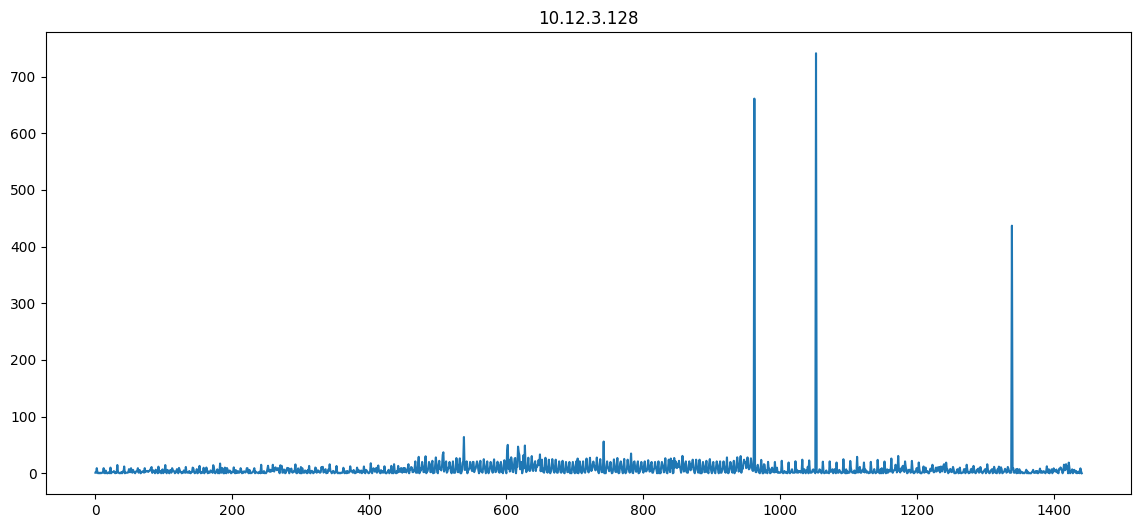

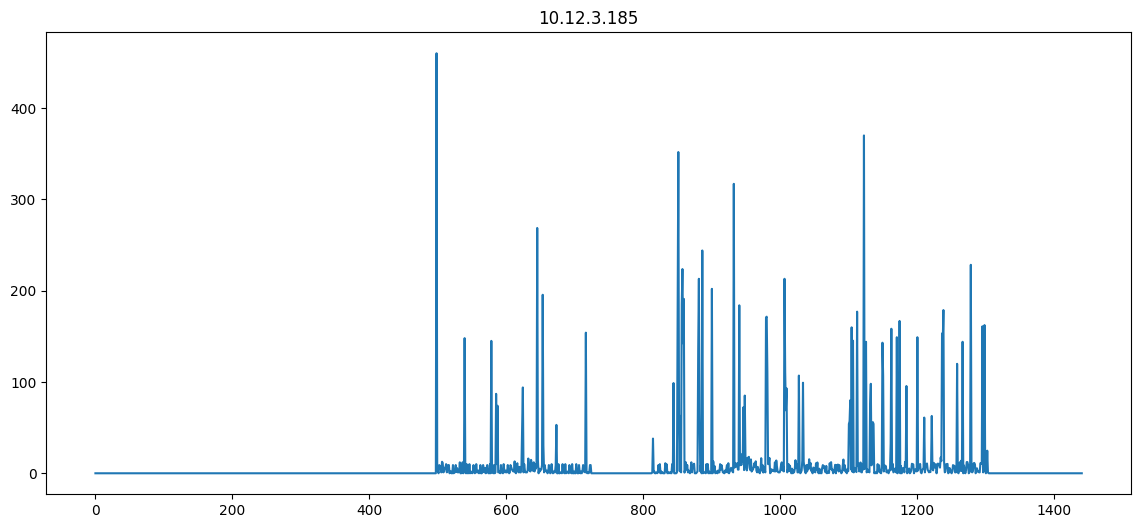

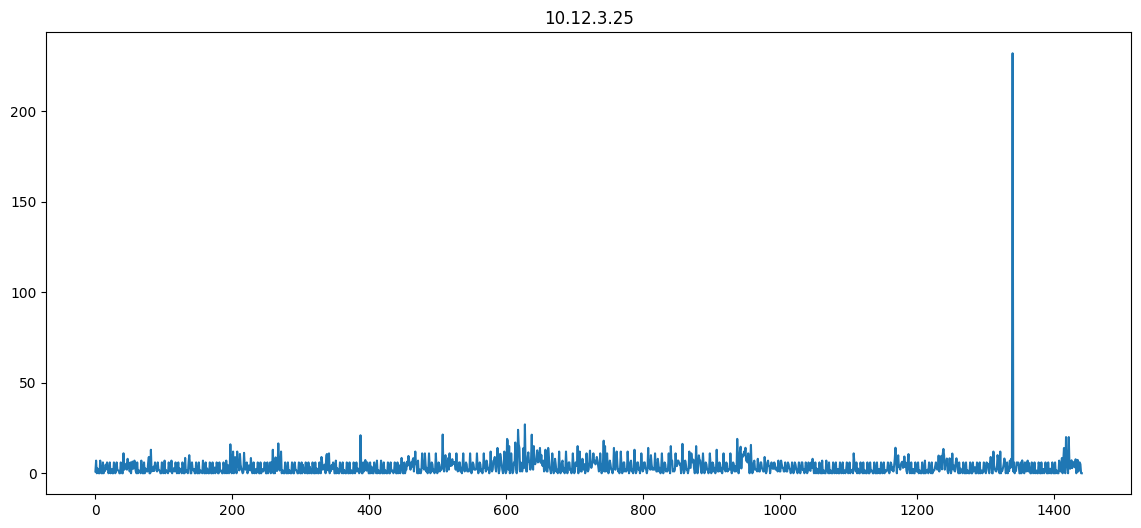

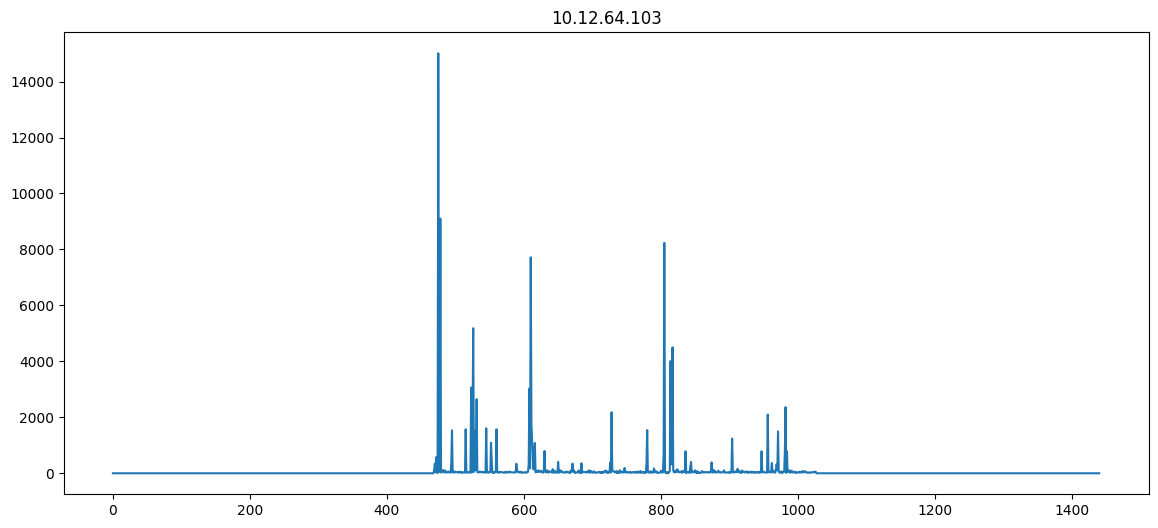

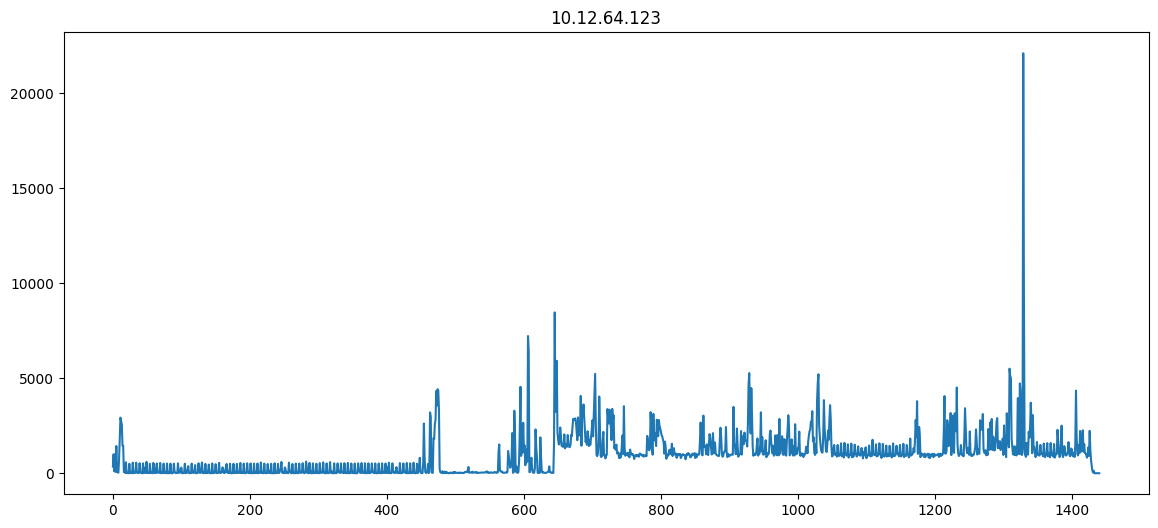

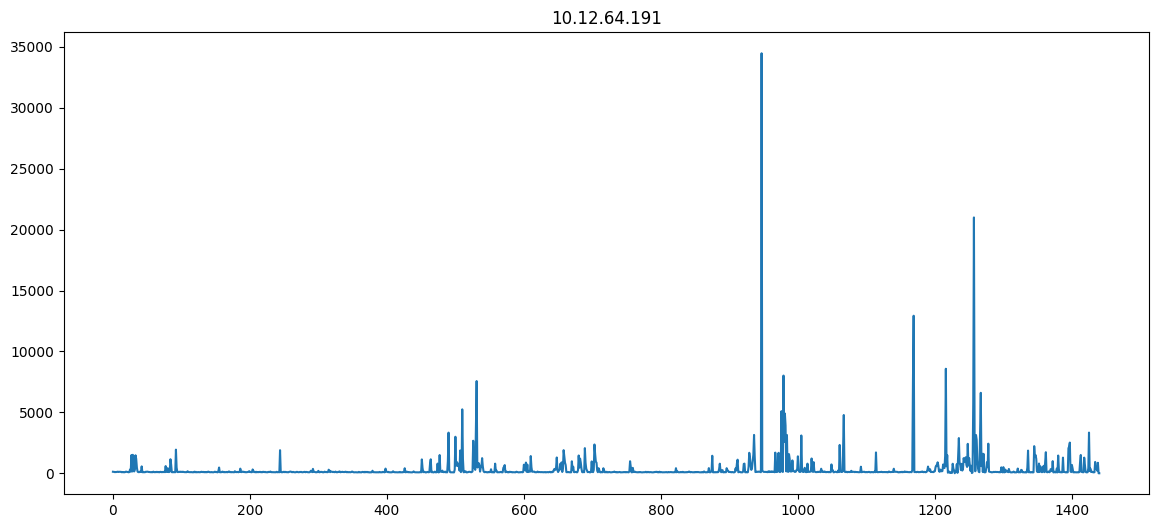

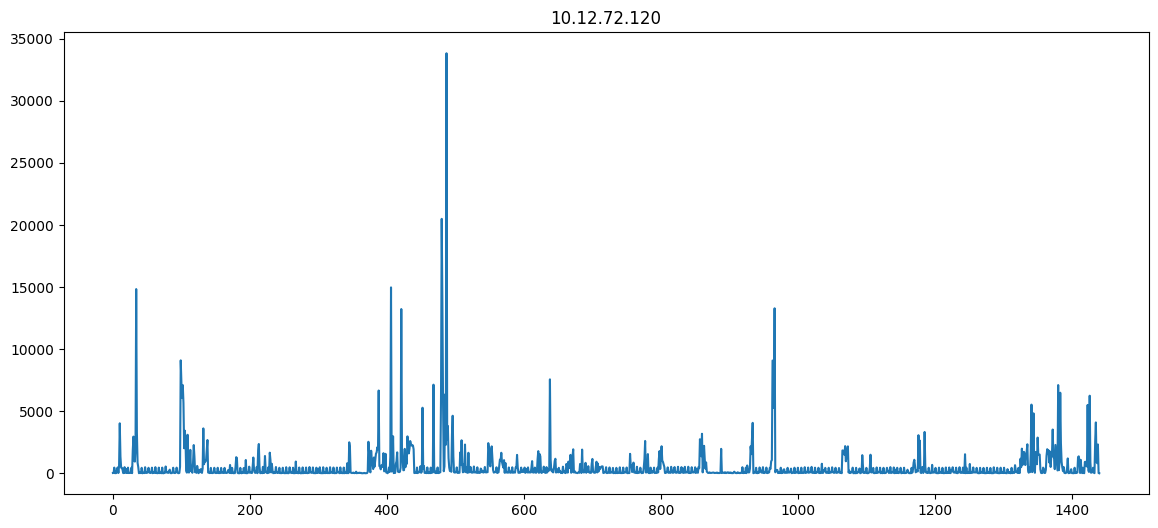

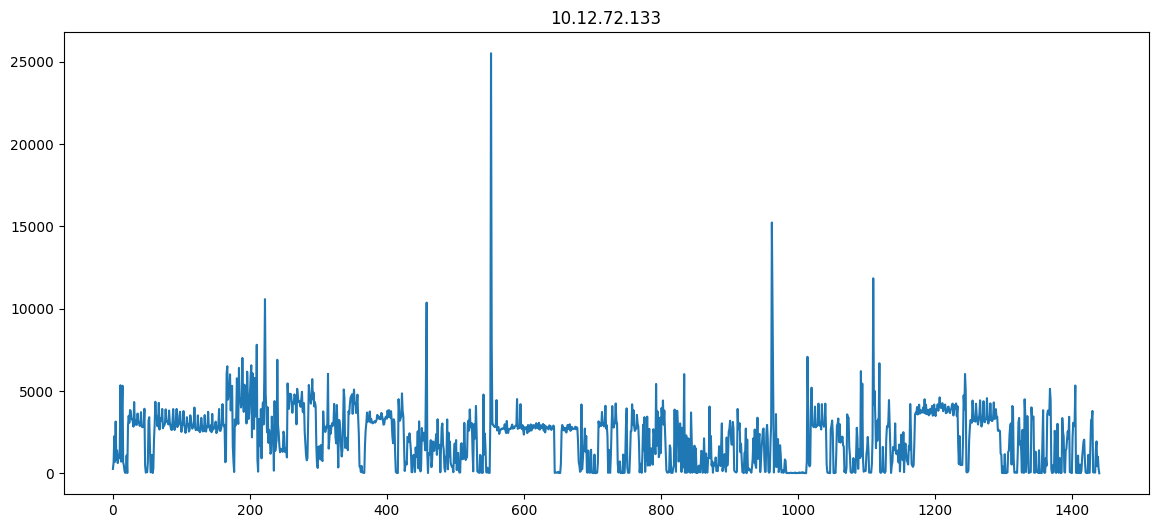

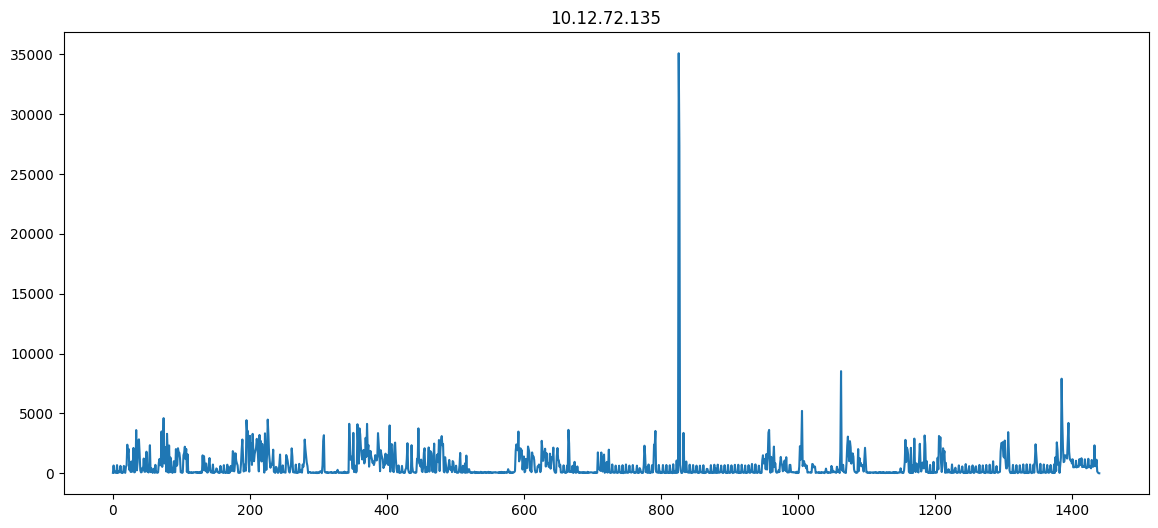

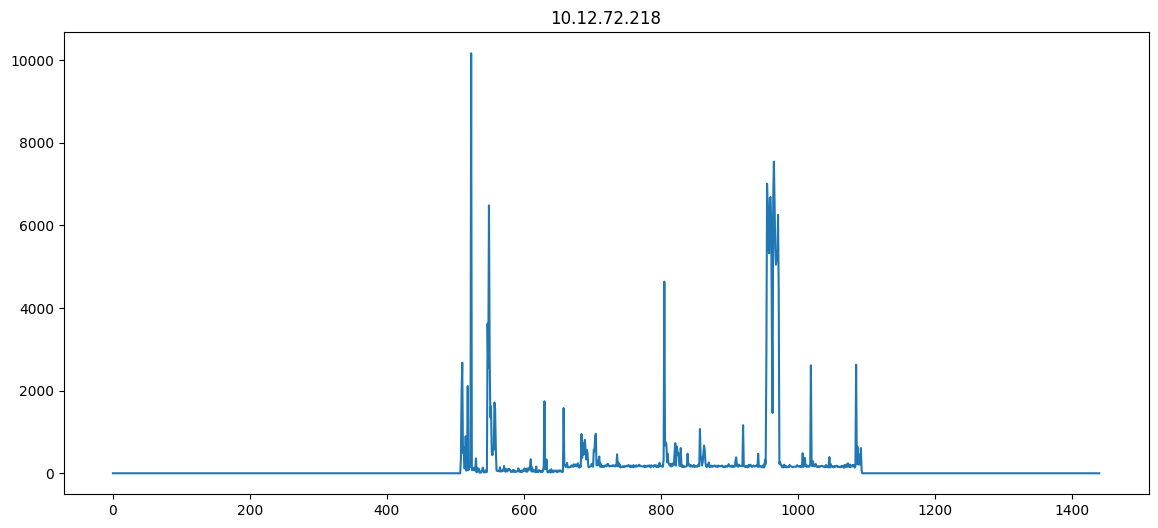

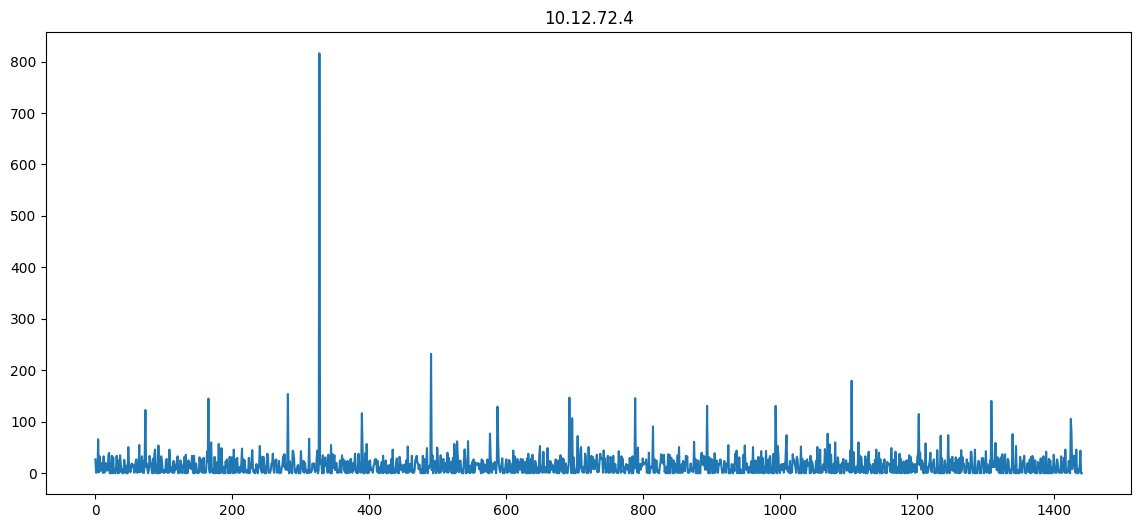

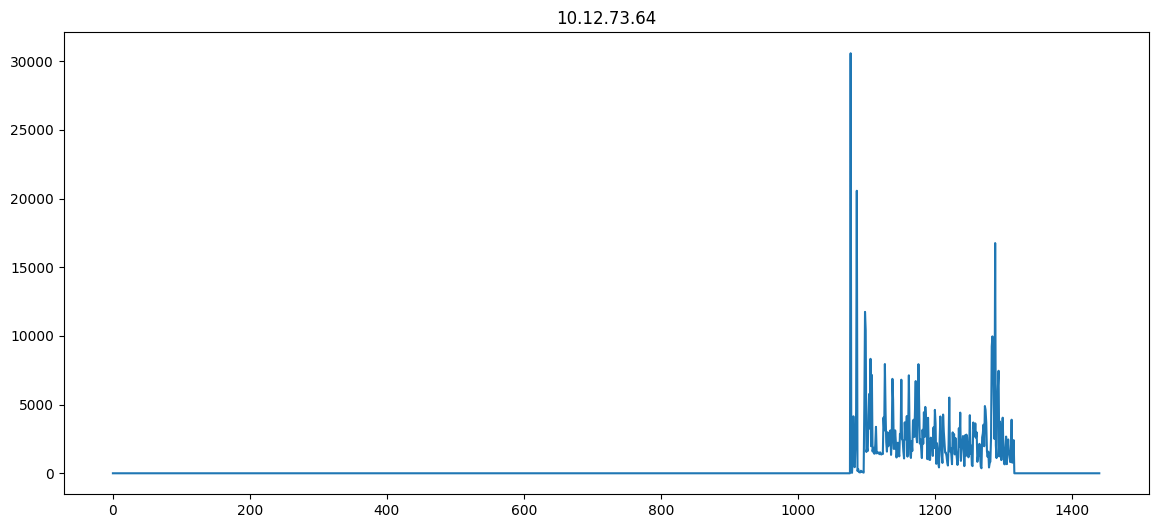

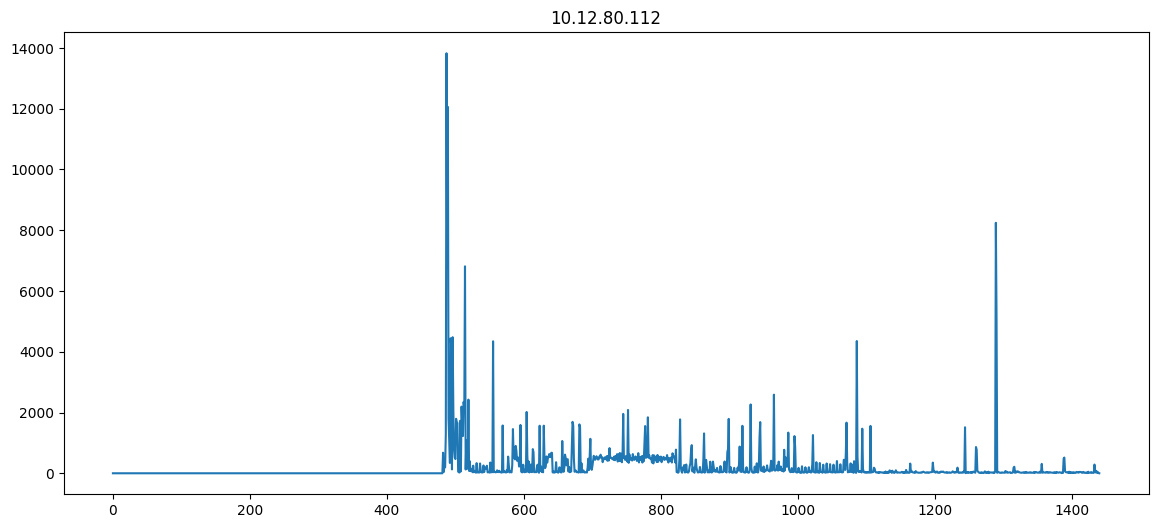

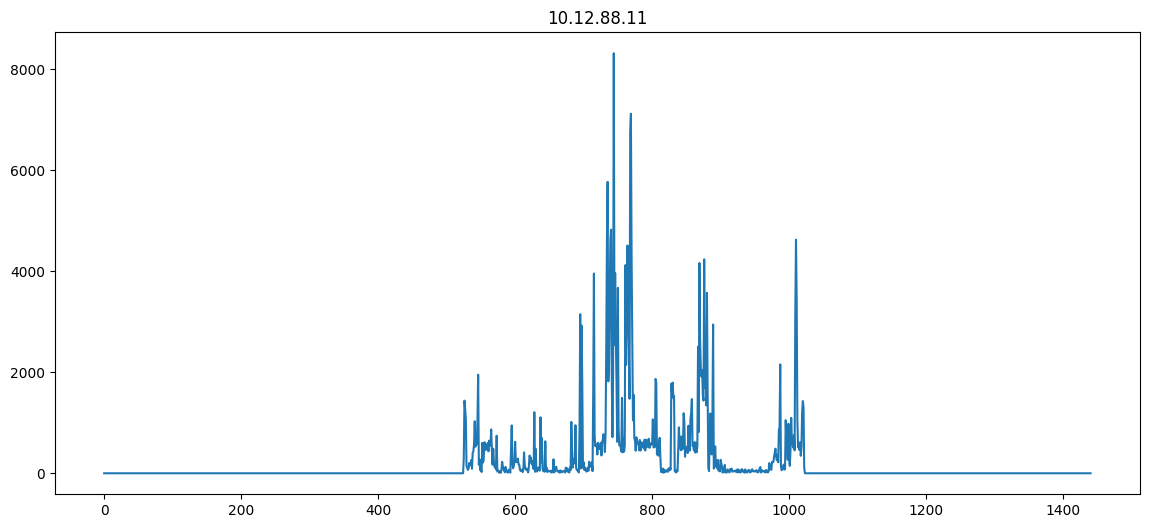

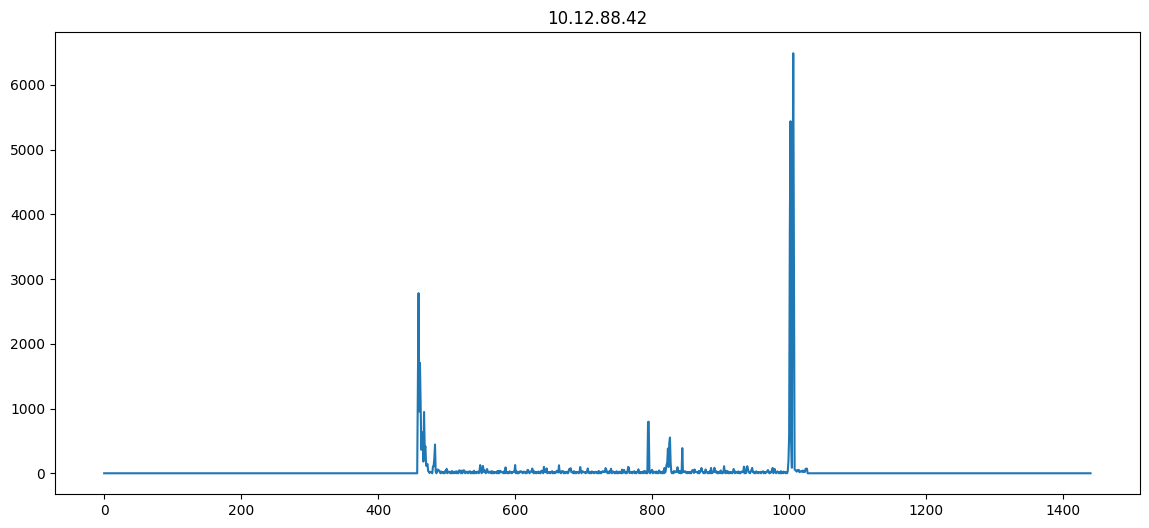

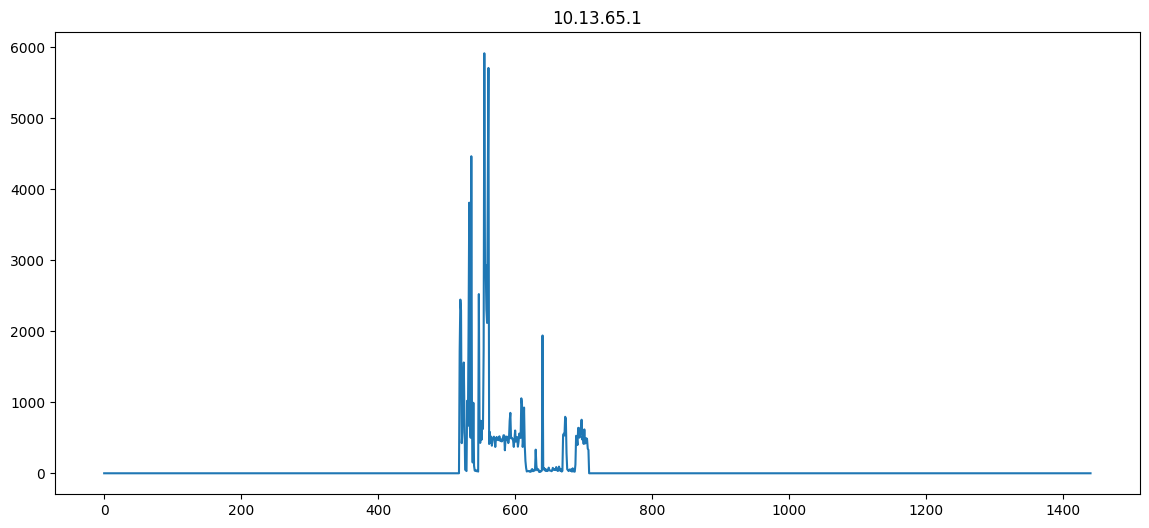

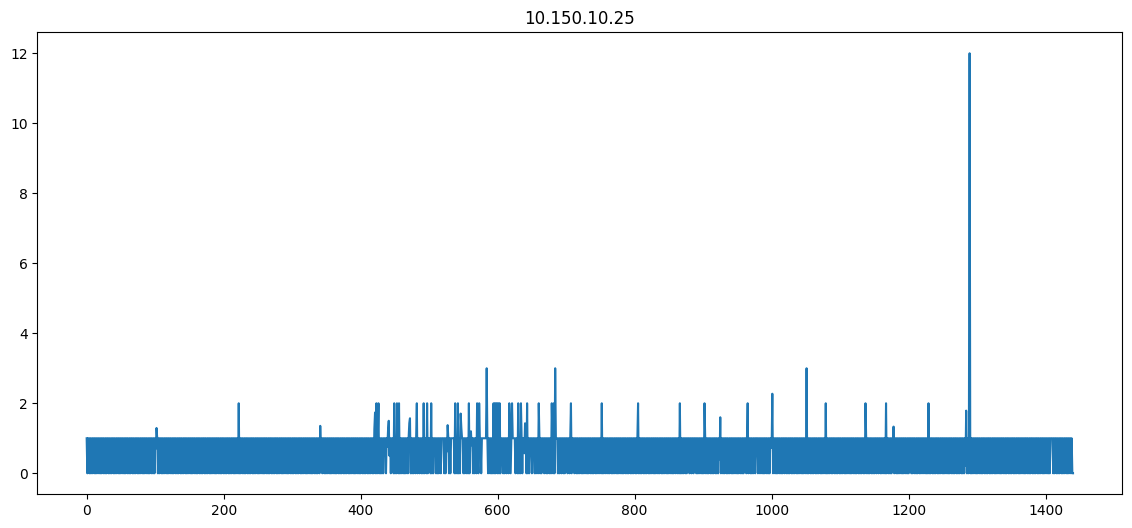

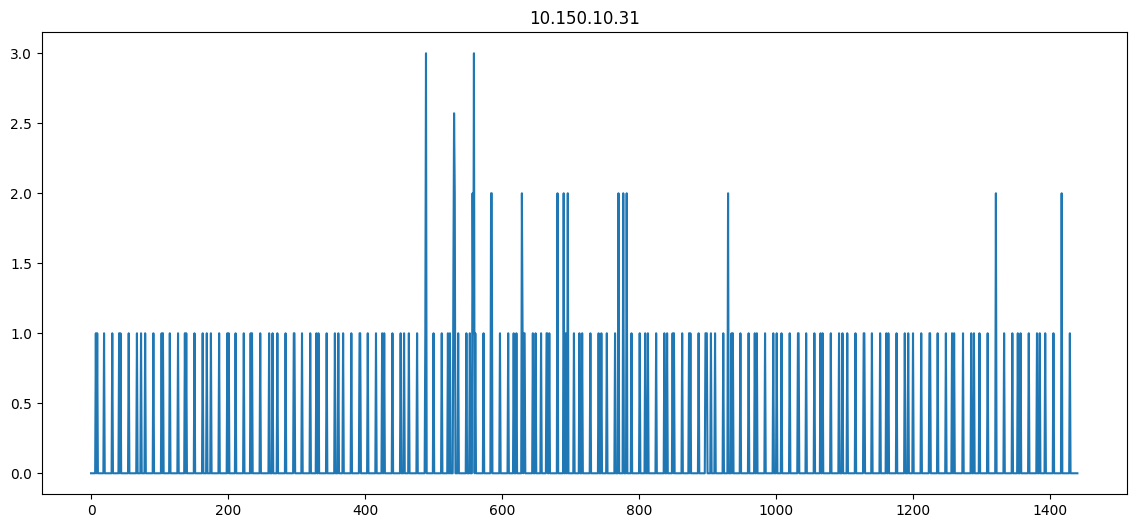

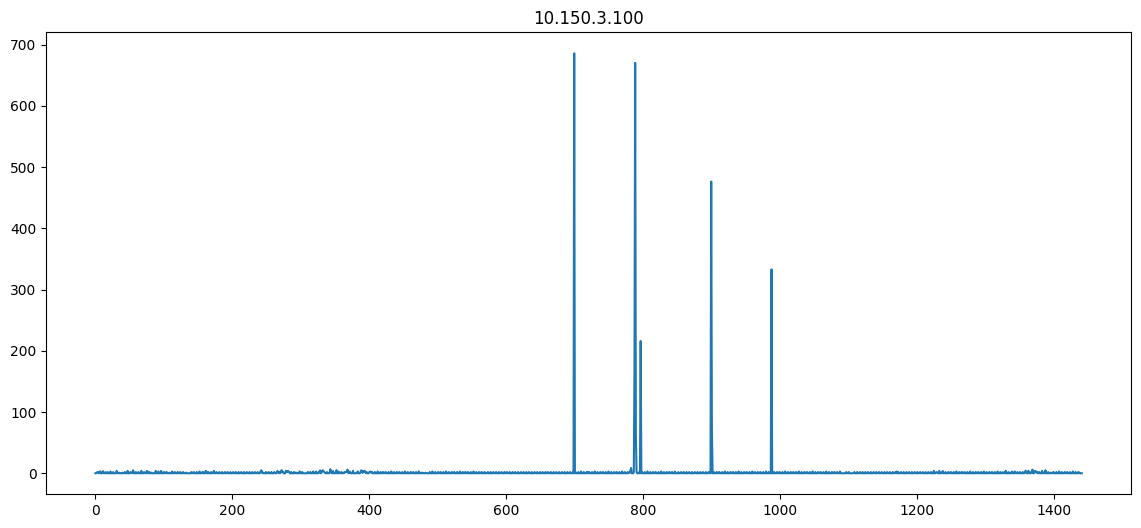

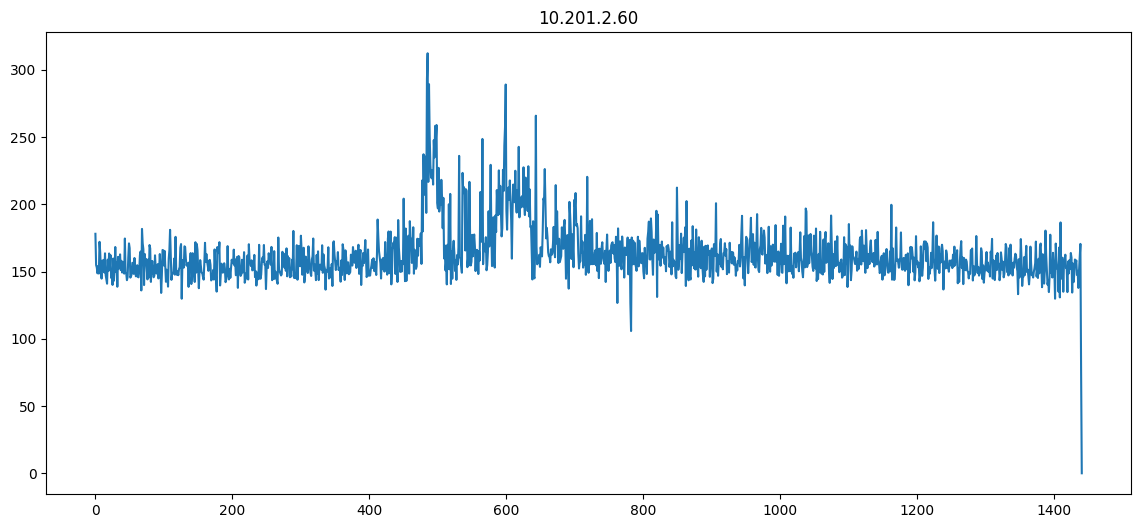

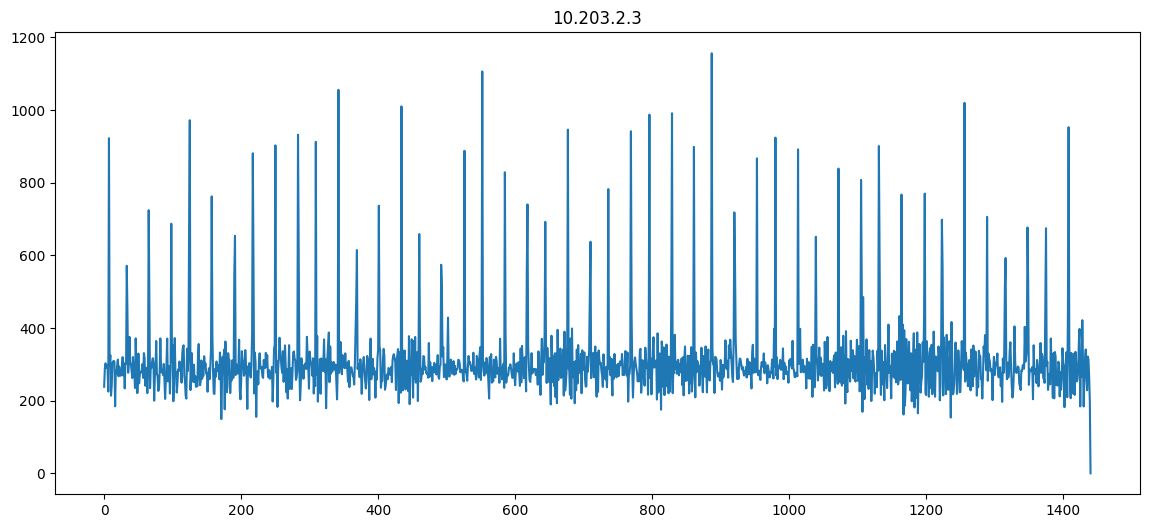

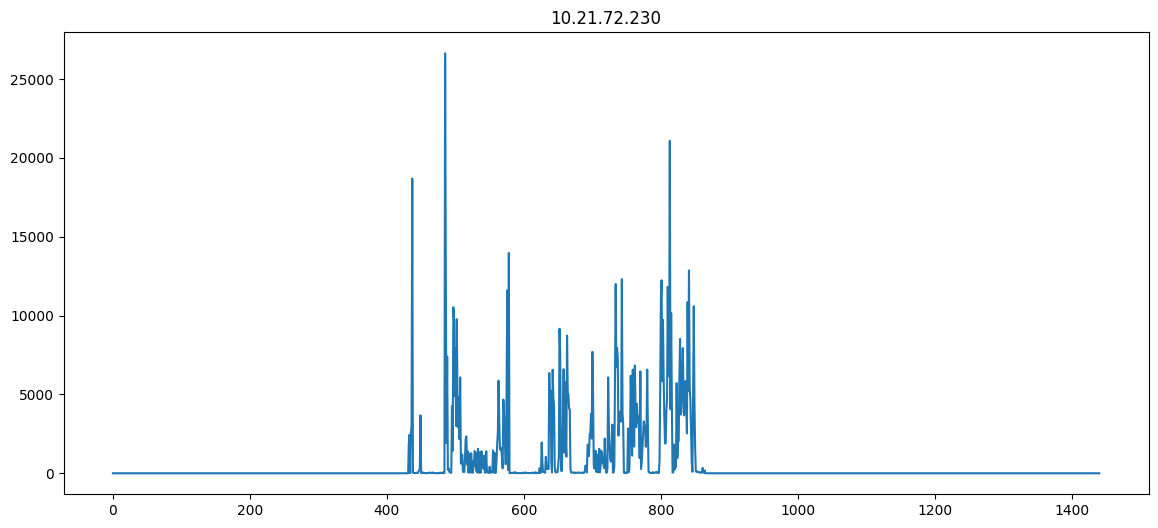

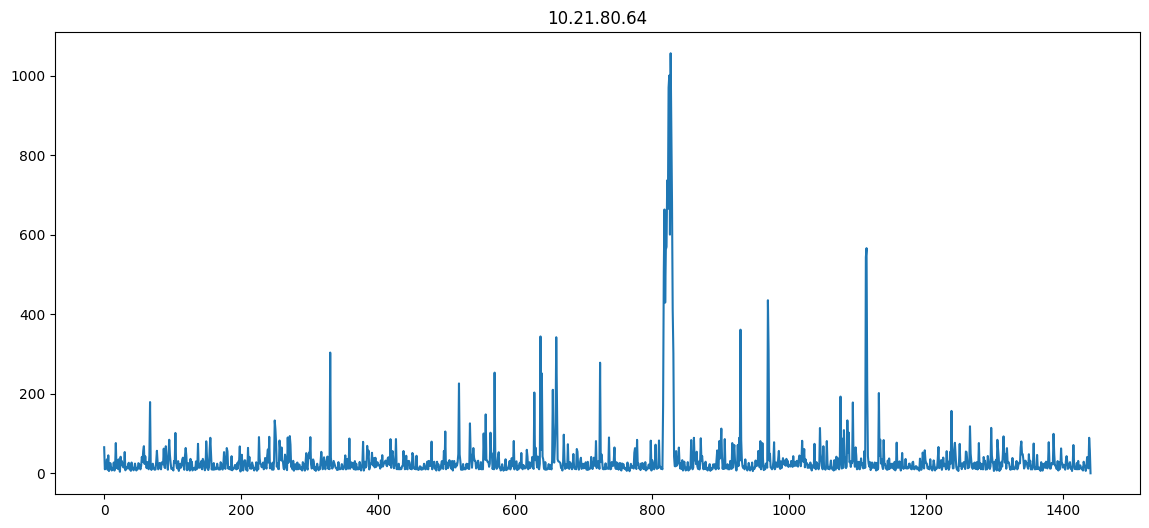

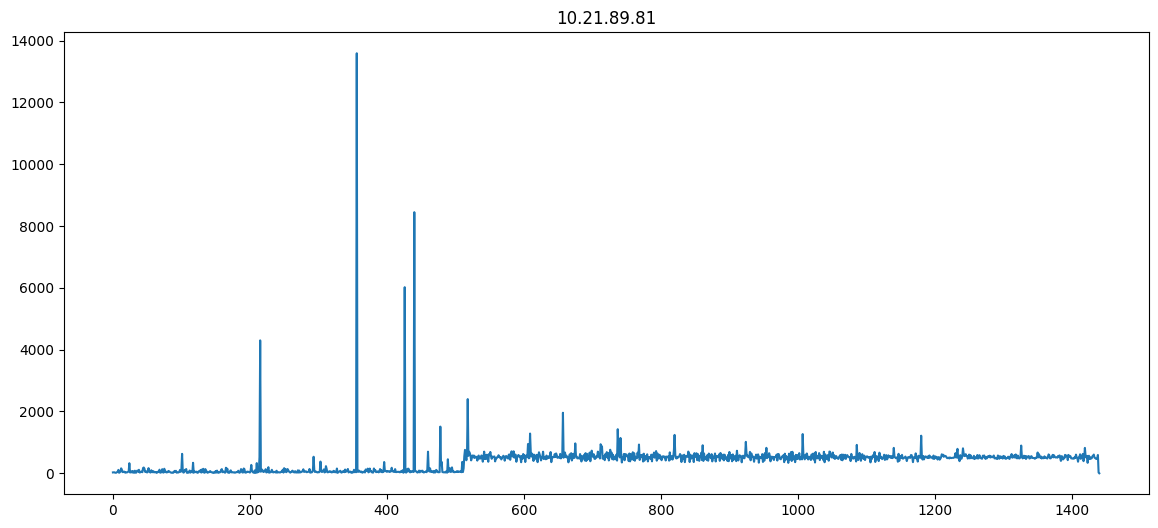

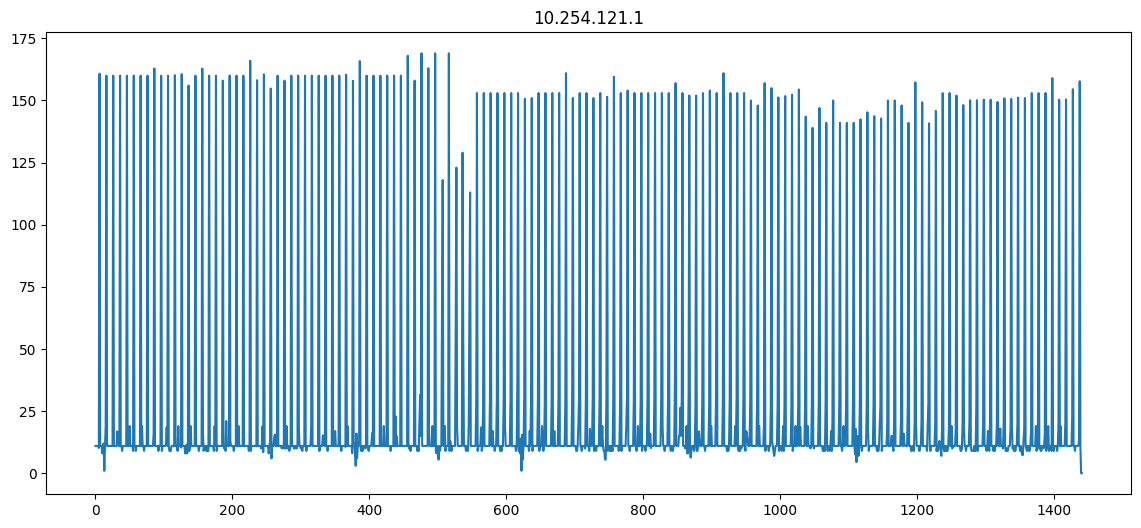

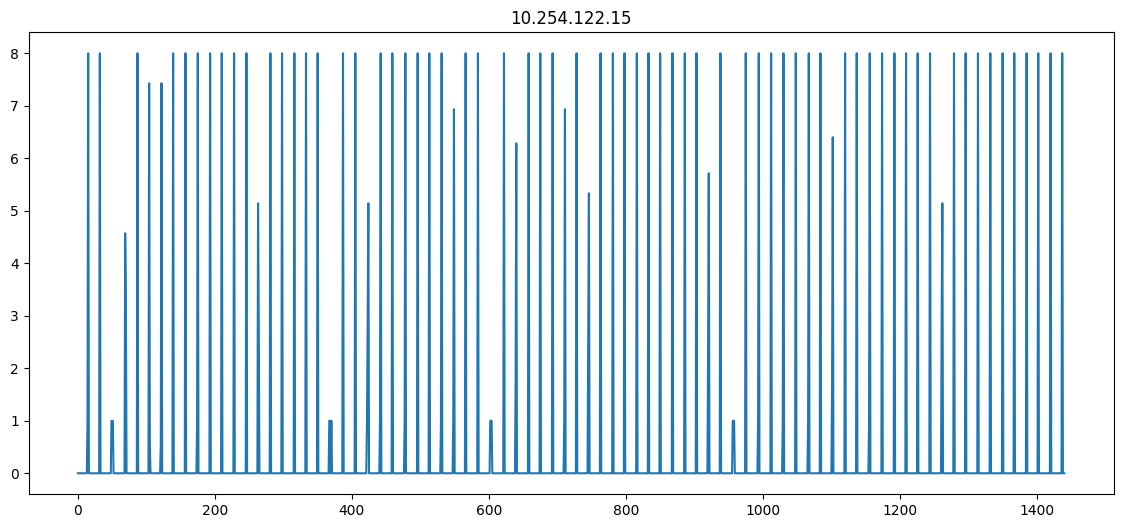

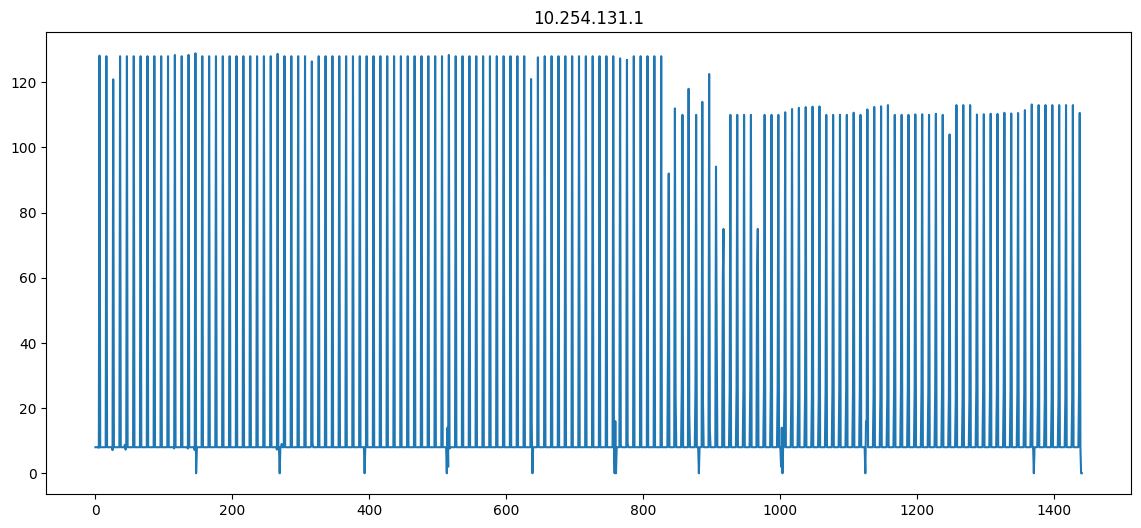

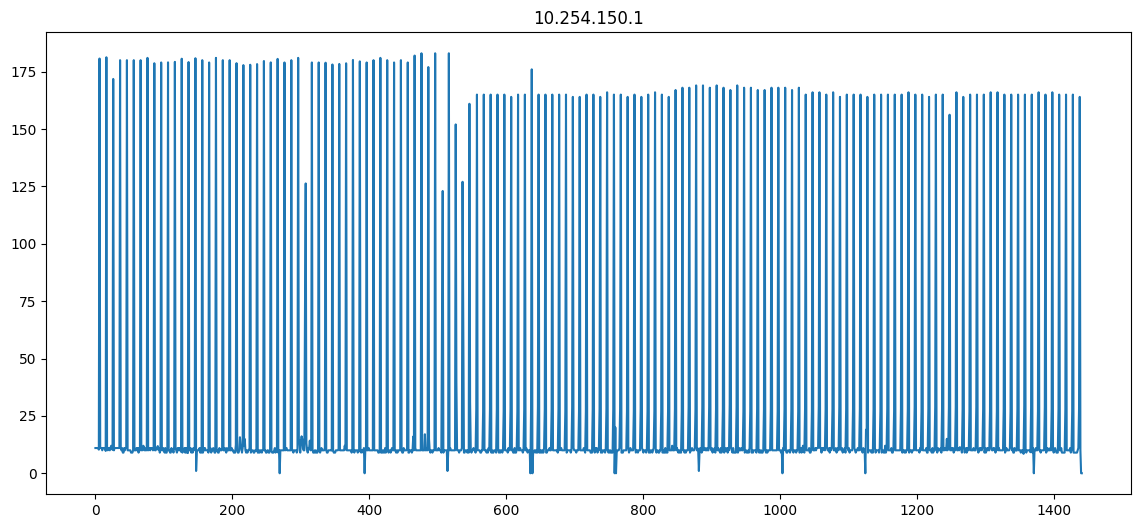

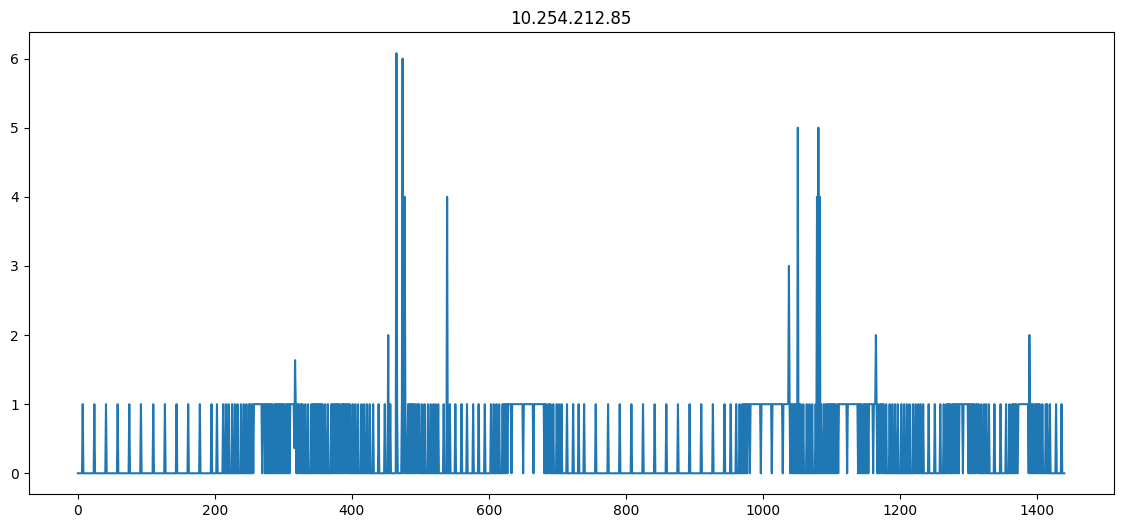

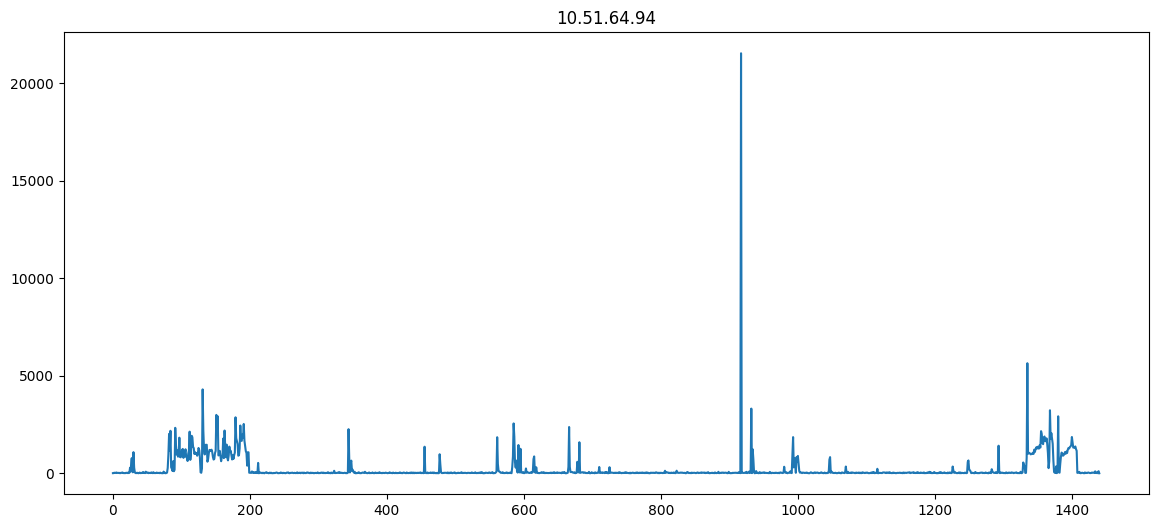

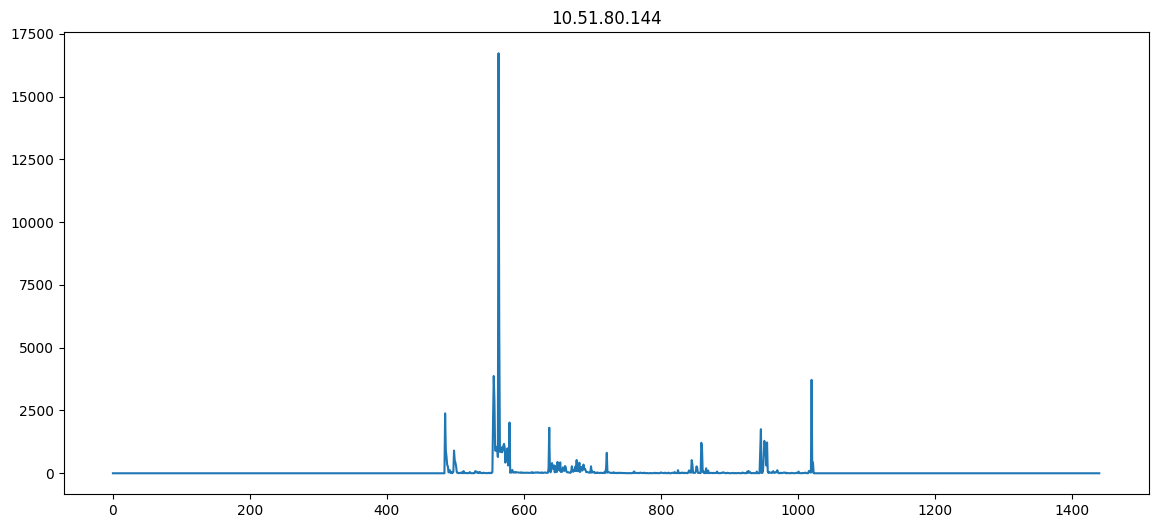

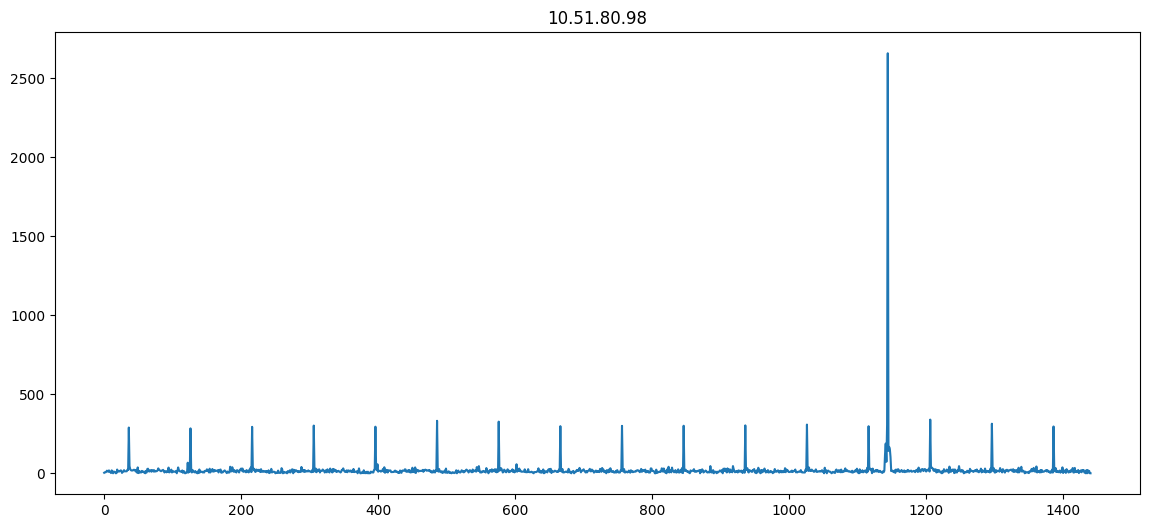

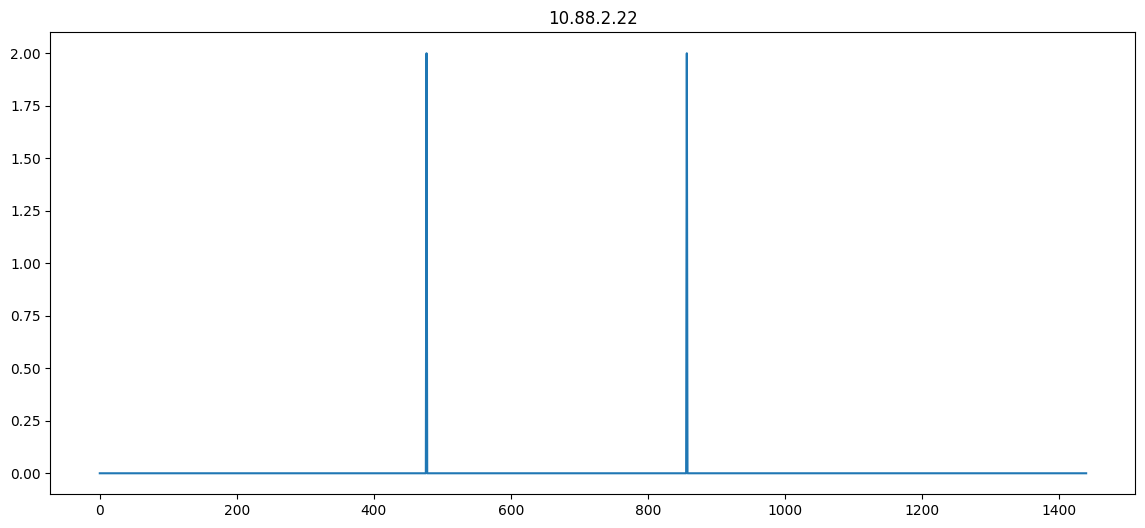

In [217]:
for ip in result[(result.index.str.startswith("10.")) & (result["cluster"] == 8)].index:
    plt.plot(ts[samples.index(ip)][0])
    plt.title(ip)
    plt.show()

In [ ]:
# print("\tSaving results...", " " * 50, flush=True)

# targetfile = f"timeseries_feature/pch/20230329/interval_{INTERVAL}_src_feature/similarity_cluster_results.npy"
# np.save(targetfile, labels)

In [ ]:
# cluster_sizes = [df.iloc[:, i].value_counts() for i in range(len(df.columns))]
# number_entries = len(df.index)
# number_features = len(df.columns)

In [ ]:
# def similarity_func(a, b):
#     return np.sum([math.e ** -(5 * cluster_sizes[i][a[i]] / number_entries) for i in np.where(a == b)[0]], dtype=np.float16) / number_features
#     # return np.sum([cluster_sizes[i][a[i]] for i in np.where(a == b)[0]], dtype=np.float16)

In [ ]:
# # similarity_matrix = pd.DataFrame(pairwise_distances(df, metric=similarity_func, n_jobs=4), index=df.index, columns=df.index, dtype=np.float16)
# similarity_matrix = pd.DataFrame(squareform(pdist(df, similarity_func)), index=df.index, columns=df.index, dtype=np.float16)
# similarity_matrix

ip             0.215.192.227  10.105.0.11  10.105.0.19  10.105.0.25  \
ip                                                                    
0.215.192.227       0.000000     0.186768     0.011597     0.186768   
10.105.0.11         0.186768     0.000000     0.011597     0.186768   
10.105.0.19         0.011597     0.011597     0.000000     0.011597   
10.105.0.25         0.186768     0.186768     0.011597     0.000000   
10.105.0.3          0.012878     0.012878     0.006104     0.012878   
...                      ...          ...          ...          ...   
99.2.14.146         0.181396     0.181396     0.006104     0.181396   
99.3.100.255        0.011597     0.011597     0.356934     0.011597   
99.3.103.221        0.186768     0.186768     0.011597     0.186768   
99.3.106.98         0.181396     0.181396     0.006104     0.181396   
99.3.118.211        0.186768     0.186768     0.011597     0.186768   

ip             10.105.0.3  10.105.0.5  10.105.0.7  100.101.17.106  \
ip                                                                  
0.215.192.227    0.012878    0.018387    0.012878        0.186768   
10.105.0.11      0.012878    0.018387    0.012878        0.186768   
10.105.0.19      0.006104    0.011597    0.006104        0.011597   
10.105.0.25      0.012878    0.018387    0.012878        0.186768   
10.105.0.3       0.000000    0.051544    0.019775        0.012878   
...                   ...         ...         ...             ...   
99.2.14.146      0.019775    0.012878    0.019775        0.181396   
99.3.100.255     0.006104    0.011597    0.006104        0.011597   
99.3.103.221     0.012878    0.018387    0.012878        0.186768   
99.3.106.98      0.012878    0.012878    0.012878        0.181396   
99.3.118.211     0.012878    0.018387    0.012878        0.186768   

ip             100.101.179.198  100.101.179.3  ...  99.175.160.49  \
ip                                             ...                  
0.215.192.227         0.186768       0.186768  ...       0.012878   
10.105.0.11           0.186768       0.186768  ...       0.012878   
10.105.0.19           0.011597       0.011597  ...       0.006104   
10.105.0.25           0.186768       0.186768  ...       0.012878   
10.105.0.3            0.012878       0.012878  ...       0.012878   
...                        ...            ...  ...            ...   
99.2.14.146           0.181396       0.181396  ...       0.012878   
99.3.100.255          0.011597       0.011597  ...       0.006104   
99.3.103.221          0.186768       0.186768  ...       0.012878   
99.3.106.98           0.181396       0.181396  ...       0.012878   
99.3.118.211          0.186768       0.186768  ...       0.012878   

ip             99.175.168.76  99.175.169.237  99.175.22.26  99.175.42.132  \
ip                                                                          
0.215.192.227       0.012878        0.011597      0.011597       0.008965   
10.105.0.11         0.012878        0.011597      0.011597       0.008965   
10.105.0.19         0.006104        0.054657      0.054657       0.002184   
10.105.0.25         0.012878        0.011597      0.011597       0.008965   
10.105.0.3          0.012878        0.044769      0.006104       0.008965   
...                      ...             ...           ...            ...   
99.2.14.146         0.012878        0.006104      0.006104       0.008965   
99.3.100.255        0.006104        0.066895      0.066895       0.002184   
99.3.103.221        0.012878        0.011597      0.011597       0.008965   
99.3.106.98         0.012878        0.006104      0.006104       0.008965   
99.3.118.211        0.012878        0.011597      0.011597       0.008965   

ip             99.2.14.146  99.3.100.255  99.3.103.221  99.3.106.98  \
ip                                                                    
0.215.192.227     0.181396      0.011597      0.186768     0.181396   
10.105.0.11       0.181396      0.011597      0.186768     0.1813

In [ ]:
# similarity_matrix.to_csv("timeseries_feature/interval_30_src_feature/similarity_matrix.csv")

In [ ]:
# similarity_matrix = pd.read_csv("timeseries_feature/interval_30_src_feature/similarity_matrix.csv", index_col=0, dtype=np.float16)

In [ ]:
# similarity_matrix = df.T.corr(similarity_func)
# similarity_matrix

In [ ]:
# similarity_matrix = np.zeros((len(df), len(df)), dtype=np.float32)
# for feature in df.columns:
#     print("Feature: {}".format(feature))
#     cluster_count = df[feature].value_counts()
#     for i in range(len(df)):
#         for j in range(len(df)):
#             print("\tPair: ({}, {})".format(i, j), " " * 20, end='\r')
#             if df[feature].iloc[i] == df[feature].iloc[j]:
#                 similarity_matrix[i, j] += math.e ** (-5 * (cluster_count[df[feature].iloc[i]] - 2) / len(df))
#     print()
# similarity_matrix = similarity_matrix / len(df.columns)
# similarity_matrix = pd.DataFrame(similarity_matrix, index=df.index, columns=df.index)

In [ ]:
# mathmatical constant
# gamma = 5
# num_in_cluster = value_counts()
# n_min = 2
# n = len(df)
# similarity_matrix = pd.DataFrame(0, index=df.index, columns=df.index, dtype=np.float32)
# for feature in df.columns:
#     cluster_count = df[feature].value_counts()
#     for i in df.index:
#         for j in df.index:
#             if df.loc[i, feature] == df.loc[j, feature]:
#                 similarity_matrix.loc[i, j] += math.e ** (-5 * (cluster_count[df.loc[i, feature]] - 2) / len(df))
# similarity_matrix = similarity_matrix / len(df.columns)
# similarity_matrix.head()